### Tasks for Paper:
* New methods
 * uSIF
 * GSE?
 * zero-training paper?
* Make figures for results in B&W
* Write Results/Discussion!

### Black/White Plots Code 

Taken from [here](http://olsgaard.dk/monochrome-black-white-plots-in-matplotlib.html)

In [1]:
from matplotlib import lines, markers

In [2]:
lines.lineStyles.keys()

dict_keys(['-', '--', '-.', ':', 'None', ' ', ''])

In [3]:
markers.MarkerStyle.markers.keys()

dict_keys(['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 'P', 'X', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 'None', None, ' ', ''])

In [4]:
from cycler import cycler

# Create cycler object. Use any styling from above you please
monochrome = (cycler('color', ['k']) * cycler('linestyle', ['--']) * cycler('marker', [None]))

# Print examples of output from cycler object. 
# A cycler object, when called, returns a `iter.cycle` object that iterates over items indefinitely
print("number of items in monochrome:", len(monochrome))
for i, item in zip(range(15), monochrome()):
    print(i, item)


number of items in monochrome: 1
0 {'color': 'k', 'linestyle': '--', 'marker': None}
1 {'color': 'k', 'linestyle': '--', 'marker': None}
2 {'color': 'k', 'linestyle': '--', 'marker': None}
3 {'color': 'k', 'linestyle': '--', 'marker': None}
4 {'color': 'k', 'linestyle': '--', 'marker': None}
5 {'color': 'k', 'linestyle': '--', 'marker': None}
6 {'color': 'k', 'linestyle': '--', 'marker': None}
7 {'color': 'k', 'linestyle': '--', 'marker': None}
8 {'color': 'k', 'linestyle': '--', 'marker': None}
9 {'color': 'k', 'linestyle': '--', 'marker': None}
10 {'color': 'k', 'linestyle': '--', 'marker': None}
11 {'color': 'k', 'linestyle': '--', 'marker': None}
12 {'color': 'k', 'linestyle': '--', 'marker': None}
13 {'color': 'k', 'linestyle': '--', 'marker': None}
14 {'color': 'k', 'linestyle': '--', 'marker': None}


In [5]:
# ipython can also pretty pring our cycler object
monochrome

'k','--',None


# Simple Sentence Similarity

Word embeddings have become widespread in Natural Language Processing. They allow us to easily compute the semantic similarity between two words, or to find the words most similar to a target word. However, in many applications we're more interested in the similarity between two sentences or short texts. In this notebook, I compare some simple ways of computing sentence similarity and investigate how they perform.

## Data

### STS Benchmark

The STS Benchmark brings together the English data from the SemEval sentence similarity tasks between 2012 and 2017. The data is split in training, development and test data: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark


In [6]:
import pickle
import pandas as pd
import numpy as np
import scipy
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
from corpustools.corpus import classes
from corpustools.corpus import io
from corpustools.symbolsim import phono_edit_distance
from corpustools.symbolsim import string_similarity
from pathlib import Path
import tensorflow as tf

%matplotlib inline


def load_sts_dataset(filename):
    # Loads a subset of the STS dataset into a DataFrame. In particular both
    # sentences and their human rated similarity score.
    sent_pairs = []
    with tf.gfile.GFile(filename, "r") as f:
        for line in f:
            ts = line.strip().split("\t")
            sent_pairs.append((ts[5], ts[6], float(ts[4])))
    return pd.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
    sts_dataset = tf.keras.utils.get_file(
        fname="Stsbenchmark.tar.gz",
        origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
        extract=True)

    sts_dev = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
    sts_test = load_sts_dataset(os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

    return sts_dev, sts_test

sts_dev, sts_test = download_and_load_sts_data()

sts_all = sts_dev.append(sts_test)


In [7]:
sts_test[:5]

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.5
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.6
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.0
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.2
4,A man is playing a harp.,A man is playing a keyboard.,1.5


### SICK data

The SICK dataset contains 10,000 English sentence pairs labelled with their semantic relatedness and entailment relation.

In [8]:
import requests

def download_sick(f): 

    response = requests.get(f).text

    lines = response.split("\n")[1:]
    lines = [l.split("\t") for l in lines if len(l) > 0]
    lines = [l for l in lines if len(l) == 5]

    df = pd.DataFrame(lines, columns=["idx", "sent_1", "sent_2", "sim", "label"])
    df['sim'] = pd.to_numeric(df['sim'])
    return df
    
#sick_train = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_train.txt")
sick_dev = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_trial.txt")
sick_test = download_sick("https://raw.githubusercontent.com/alvations/stasis/master/SICK-data/SICK_test_annotated.txt")
sick_all = sick_dev.append(sick_test)

In [9]:
pd.set_option('max_colwidth', 800)
display(sick_all[:5])

,idx,sent_1,sent_2,sim,label
0,4,The young boys are playing outdoors and the man is smiling nearby,There is no boy playing outdoors and there is no man smiling,3.6,CONTRADICTION
1,24,A person in a black jacket is doing tricks on a motorbike,A skilled person is riding a bicycle on one wheel,3.4,NEUTRAL
2,105,Four children are doing backbends in the gym,Four girls are doing backbends and playing outdoors,3.8,NEUTRAL
3,116,A player is throwing the ball,Two teams are competing in a football match,2.9,NEUTRAL
4,119,Five children are standing in front of a wooden hut,Five children are standing in a wooden hut,4.2,NEUTRAL


#### Create dataframe with all sentences from SICK and STS

In [10]:
sick_all = sick_all.loc[:, 'sent_1':'sim']

all_data = pd.concat([sick_all, sts_all])

### Load [IPhoD](http://www.iphod.com) (Irvine Phonotactic Online Dictionary of English) corpus

* Uses **ARPABET** transcriptions and defaults to Hayes 2009 features
* Download if not already available
* Also download SPE Features
* Download [CMU ARPABET](http://www.speech.cs.cmu.edu/cgi-bin/cmudict) phonological transcription dictionary and convert to list of Word classes with ARPABET transcriptions

In [11]:
import csv

def read_cmu(f):
    cmu_dict = {}
    with open(f) as tsv:
        tsv_reader = csv.reader(tsv, delimiter="\t", quoting=csv.QUOTE_NONE)
        for row in tsv_reader:
            spelling = row[0]
            transcription = classes.lexicon.Transcription(row[1].split())
            
            try:
                Word = classes.lexicon.Word(symbol=spelling)
            except:
                continue
                
            setattr(Word, 'transcription', transcription)
                
            cmu_dict[spelling] = Word
        
    return cmu_dict

In [12]:
if not Path('/home/rohit/data/iphod').is_file():
    io.binary.download_binary('iphod', '/home/rohit/data/iphod')

iphod = io.binary.load_binary('/home/rohit/data/iphod')

if not Path('/home/rohit/data/arpabet2spe').is_file():
    io.binary.download_binary('arpabet2spe', '/home/rohit/data/arpabet2spe')

arpabet2spe = io.binary.load_binary('/home/rohit/data/arpabet2spe')

if not Path('/home/rohit/data/arpabet2hayes').is_file():
    io.binary.download_binary('arpabet2hayes', '/home/rohit/data/arpabet2hayes')

arpabet2hayes = io.binary.load_binary('/home/rohit/data/arpabet2hayes')

if not Path('/home/rohit/data/cmudict.0.7a_SPHINX_40').is_file():
    print('download plaintext CMU dict!')
else:
    cmu_dict = read_cmu('/home/rohit/data/cmudict.0.7a_SPHINX_40')
    

#### Length of Word List:

In [13]:
len(iphod.wordlist)

47893

In [14]:
len(cmu_dict)

133029

In [15]:
iphod.wordlist.get('Hello').transcription

HH.AH.L.OW

####  Features Lists

In [16]:
arpabet2spe.features

['EXTRA',
 'LONG',
 'ant',
 'back',
 'cont',
 'cor',
 'del_rel',
 'distr',
 'glot_cl',
 'hi_subgl_pr',
 'high',
 'lat',
 'low',
 'mv_glot_cl',
 'nasal',
 'round',
 'son',
 'strid',
 'tense',
 'voc',
 'voice']

In [17]:
for feature in arpabet2hayes.features:
    print(feature.upper(), ', ', end="")

ANTERIOR , APPROXIMANT , BACK , CONSONANTAL , CONSTRICTED GLOTTIS , CONTINUANT , CORONAL , DELAYED_RELEASE , DIPHTHONG , DISTRIBUTED , DORSAL , FRONT , FRONT-DIPHTHONG , HIGH , LABIAL , LABIODENTAL , LATERAL , LONG , LOW , NASAL , ROUND , SEGMENT , SONORANT , SPREAD GLOTTIS , STRESS , STRIDENT , SYLLABIC , TAP , TENSE , TRILL , VOICE , 

#### Example Word Transcriptions

In [18]:
cmu_dict.get('establishment'.upper()).transcription

IH.S.T.AE.B.L.IH.SH.M.AH.N.T

In [19]:
with open('dict.pkl', 'wb') as f:
    pickle.dump([cmu_dict, arpabet2hayes],f)

## Preparation

First we need to do some preparation: some of our models require the sentences to be tokenized, some do not. For that reason we'll make a simple Sentence class where we keep both the raw sentence and the tokenized sentence. The individual methods below will then pick the input they need.

In [20]:
import nltk

STOP = set(nltk.corpus.stopwords.words("english"))

class Sentence:
    
    def __init__(self, sentence):
        self.raw = sentence
        normalized_sentence = sentence.replace("‘", "'").replace("’", "'")
        self.tokens = [t.lower() for t in nltk.word_tokenize(normalized_sentence)]
        self.tokens_without_stop = [t for t in self.tokens if t not in STOP]
        self.tokens_cased = [t for t in nltk.word_tokenize(normalized_sentence)]
        self.tokens_cased_without_stop = [t for t in self.tokens_cased if t not in STOP]


Next, we're going to use the popular [Gensim](https://radimrehurek.com/gensim/) library to load two sets of widely used pre-trained word embeddings: 
[word2vec](https://www.tensorflow.org/tutorials/word2vec) and [GloVe](https://nlp.stanford.edu/projects/glove/). 

In [21]:
import gensim
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

PATH_TO_WORD2VEC_MODEL = os.path.expanduser("~/data/word2vec/word2vec")

if not Path(PATH_TO_WORD2VEC_MODEL).is_file():    
    PATH_TO_WORD2VEC = os.path.expanduser("~/data/word2vec/GoogleNews-vectors-negative300.bin")
    word2vec = gensim.models.KeyedVectors.load_word2vec_format(PATH_TO_WORD2VEC, binary=True)
    word2vec.save(PATH_TO_WORD2VEC_MODEL)
else:
    word2vec = gensim.models.KeyedVectors.load(PATH_TO_WORD2VEC_MODEL)

To load Glove, we have to convert the downloaded GloVe file to word2vec format and then load the embeddings into a Gensim model. This will take some time.

In [22]:
PATH_TO_GLOVE_MODEL = os.path.expanduser("~/data/glove/glove")

if not Path(PATH_TO_GLOVE_MODEL).is_file():    
    tmp_file = "/tmp/glove.840B.300d.w2v.txt"
    PATH_TO_GLOVE = os.path.expanduser("~/data/glove/glove.840B.300d.txt")
    glove2word2vec(PATH_TO_GLOVE, tmp_file)
    glove = gensim.models.KeyedVectors.load_word2vec_format(tmp_file)
    glove.save(PATH_TO_GLOVE_MODEL)
else:
    glove = gensim.models.KeyedVectors.load(PATH_TO_GLOVE_MODEL)

#### InferSent Model Paths

In [23]:
PATH_TO_FASTTEXT = os.path.expanduser("~/data/fasttext/crawl-300d-2M.vec")
PATH_TO_GLOVE = os.path.expanduser("~/data/glove/glove.840B.300d.txt")

Finally, in order to compute weighted averages of word embeddings later, we are going to load a file with word frequencies. These word frequencies have been collected from Wikipedia and saved in a tab-separated file. 

In [24]:
import csv

PATH_TO_FREQUENCIES_FILE = "data/sentence_similarity/frequencies.tsv"
PATH_TO_DOC_FREQUENCIES_FILE = "data/sentence_similarity/doc_frequencies.tsv"

def read_tsv(f):
    frequencies = {}
    with open(f) as tsv:
        tsv_reader = csv.reader(tsv, delimiter="\t")
        for row in tsv_reader: 
            frequencies[row[0]] = int(row[1])
        
    return frequencies
        
frequencies = read_tsv(PATH_TO_FREQUENCIES_FILE)
doc_frequencies = read_tsv(PATH_TO_DOC_FREQUENCIES_FILE)
doc_frequencies["NUM_DOCS"] = 1288431


In [25]:
frequencies = {k.upper():v for k,v in frequencies.items()}

#### Function to find Phonetic Edit Distances to $N=1000$ most semantically similar words

* **Input**: DataFrame with *sent_1* and *sent_2*
* **Output**: New DataFrame with unique tokens in dataset as index with phonetic distance to $N$ most similar words
* For either Word2Vec or GloVe
* Filter stop words (only with content words)

Test:

In [26]:
phono_edit_distance.phono_edit_distance(cmu_dict.get('cat'.upper()), 
                                        cmu_dict.get('bat'.upper()),
                                        'transcription',
                                        arpabet2spe)
                                        

5

#### We need to:
* Convert all unique tokens in STS datasets to phonetic transcriptions (if they exist in the corpus and in the word2vec or GloVe models)
* Find phonological edit distance to the $N=1000$ most semantically similar words according to the *word2vec* or *GloVe* models
 * Found **GloVe** works a lot better for this
* Keep all words for phonological edit distance under $20$ as a set of possible replacements.
* Convert similarities to a probability distribution for each unique token
 * Use RBF kernel (described below)
* Given an error rate, sample from the distribution and replace some words


#### Probability computations:
* Variables:
 * w2v vs. **GloVe**
 * content vs **stop words included**
 * SPE vs **Hayes** Features
 * Datset Used - **ALL**

#### Tests:
* Compare which sentence embedding method performs best on STS tasks with ASR errors
* Compare similarities of sentence embeddings with and without ASR errors to see how robust each sentence embedding method is to errors in ASR

In [27]:
sentences_df = pd.concat([sts_all.loc[:, 'sent_1':'sent_2'], sick_all.loc[:, 'sent_1':'sent_2']])


In [28]:
def find_distances(df, corpus_dict, features, use_stoplist=True, model=glove, N=1000):
    # Copy to avoid modifying df
    df2 = df.copy()
    
    # Convert dict keys and and word list to upper case for comparison purposes
    corpus_words = [word.upper() for word in list(corpus_dict.keys())]
        
    # Combine sent1 and sent2 into single column, filter stop, and tokenize
    df2['text'] = df2['sent_1'] + ' ' + df2['sent_2']
    df2['text'] = df2['text'].apply(Sentence)
    if use_stoplist:
        df2['text'] = df2['text'].apply(lambda x: x.tokens_cased_without_stop)
    else:
        df2['text'] = df2['text'].apply(lambda x: x.tokens_cased)
     
    # Create set of all unique tokens in both sentence 1 and sentence 2
    set_of_unique_tokens = set()
    df2['text'].apply(set_of_unique_tokens.update)
    
    # Filter set of unique tokens to only those that are in the model and the phonological corpus
    set_of_unique_tokens = {token for token in set_of_unique_tokens if 
                            token in model and token.upper() in corpus_words}
    
    # Empty lists for word tuples (index) and distances (column) of resulting dataframe
    distances = []
    word_tuples = []
    
    # Loop through set of unique tokens and compute phon edit distances to N most semantically similar words
    for token in log_progress(set_of_unique_tokens, every=1):
        # Add Entry for same word and dist=0
        #word_tuples.append((token,token))
        #distances.append(0.)
        
        similar_set = model.most_similar(token, topn=N)
        
        # Only keep words
        similar_set = [item[0] for item in similar_set]
        
        similar_set = [sim_word for sim_word in similar_set if 
                       sim_word in model and sim_word.upper() in corpus_words
                       and token.upper() != sim_word.upper()]
        
        for sim_word in similar_set:
            distance = phono_edit_distance.phono_edit_distance(corpus_dict.get(token.upper()), 
                                                               corpus_dict.get(sim_word.upper()),
                                                               'transcription',
                                                               features
                                                              )
            word_tuples.append((token, sim_word))
            distances.append(distance)
    
    index = pd.MultiIndex.from_tuples(tuples=word_tuples, names=['STS Word', 'Similar Word from Model'])
    columns = ['Phono Edit Distance']
    
    dist_frame = pd.DataFrame(distances, index=index, columns=columns)
        
    return dist_frame
    


            
    

In [29]:
if not Path('glove_hayes_all.pkl').is_file():
    distances = find_distances(sentences_df, cmu_dict, arpabet2hayes, model=glove, use_stoplist=False)
    with open('glove_hayes_all.pkl', 'wb') as f:
        pickle.dump(distances, f)
    
else:
    with open('glove_hayes_all.pkl', 'rb') as f:
        distances = pickle.load(f)


if not Path('glove_spe_all.csv').is_file():
    distances = find_distances(sentences_df, cmu_dict, arpabet2spe, model=glove, use_stoplist=False)
    distances.to_csv('glove_spe_all.csv')
else:
    df = pd.read_csv('glove_spe_all.csv')
    tuples = list(zip(df['STS Word'], df['Similar Word from Model']))
    
    index = pd.MultiIndex.from_tuples(tuples=tuples, names=['STS Word', 'Similar Word from Model'])
    distances = pd.DataFrame(df['Phono Edit Distance'].values, index=index, columns=['Phono Edit Distance'])

In [30]:
filtered = distances.loc[distances['Phono Edit Distance'] < 60]

dist_group = filtered.groupby(level='STS Word', group_keys=False)


def max_confusion_words(distances, nwords=15):
    if len(distances) > nwords:
        return distances.nsmallest(nwords, 'Phono Edit Distance')
    else:
        return distances
    
    
distances_filtered = dist_group.apply(max_confusion_words).groupby(level='STS Word', group_keys=False)

### **RBF Kernel** to convert distanes to probabilities

* Approximates Gaussian
* Normalize by sum

$$ \text{Probability}(\text{word}_i) =  \frac{\text{exp}(-\text{dist}_i^2 / 2\sigma^2)}{\sum_{j=1}^N{\text{exp}(-\text{dist}_j^2/ 2\sigma^2)}} $$



### Still need to try:

* Parallel to speed up
 * GPU Acceleration with CUDA and numba
 * If successful, can look for phonetic similarities over entire dataset
* Find optimal $\sigma$ value
 * Seems to work reasonably well with $\sigma = \text{mean dist.}$


In [31]:
def dist_to_prob(dist, sigma, total):
    prob = np.exp(-1 * np.square(dist) / (2*np.square(sigma))) / total
    return prob


In [32]:
def find_probabilities(df):
    df2 = df.copy()
    
    index = df2.index
    
    # Set sigma    
    sigma = np.mean(df2['Phono Edit Distance'].values)
    
    #sigma = 1
    
    total = np.sum(np.exp(-1 * np.square(df2['Phono Edit Distance'].values) / (2*np.square(sigma))))
    
    df2['probability'] = df2['Phono Edit Distance'].apply(lambda x: dist_to_prob(x, sigma, total))
        
    return df2

In [33]:
probs = distances_filtered.apply(find_probabilities)

In [34]:
%precision %.4f
pd.options.display.float_format = '{:,.4f}'.format

probs = probs.sort_values(['STS Word', 'probability'], ascending=[True, False])

In [35]:
probs.loc['Syria']

,Phono Edit Distance,probability
Similar Word from Model,,
Syrian,5.7500,0.0941
syrian,5.7500,0.0941
Sharia,6.2500,0.0914
Assyria,6.5000,0.0900
Korea,10.2500,0.0664
Cilicia,11.0000,0.0614
Saudia,11.2500,0.0598
Cypriot,11.2500,0.0598
Syrians,11.7500,0.0565


### Simulate ASR Errors

* Set **error rate** $err = 0.10$
* Generate random number between $0$ and $1$ for each word in STS dataset, substitute words less than the threshold $err$

In [36]:
import re

def identify_subs(tokens, error_rate):
    x = {word:np.random.rand() for word in tokens}
    filtered = {k:v for k, v in x.items() if v < error_rate}
    
    # Return randomly selected tokens list
    return list(filtered.keys())


def pick_similar_word(prob_df):
    try:
        word = (prob_df.sample(n=1, weights=prob_df.probability)).index.remove_unused_levels().levels[1][0]
    except:
        return ''
    return word


def replace_error_words(probs_df, sentence, error_rate):
    tokens = sentence.tokens_cased
    
    words_to_replace = identify_subs(tokens, error_rate=error_rate)
    
    probs = probs_df.loc[(words_to_replace, slice(None)), :]
    
    probs_group = probs.groupby(level='STS Word')
    
    sim_words_dict = probs_group.apply(pick_similar_word).to_dict()
    
    for k,v in list(sim_words_dict.items()):
        sentence.tokens_cased = [re.sub(r"\b"+k+r"\b",v,w) for w in sentence.tokens_cased]
    
    sentence.tokens = [w.lower() for w in sentence.tokens_cased]
    sentence.tokens_without_stop = [w for w in sentence.tokens if w not in STOP]
    sentence.tokens_cased_without_stop = [w for w in sentence.tokens_cased if w not in STOP]
    
    sentence.raw = " ".join(sentence.tokens_cased)
    
    return sentence
    

def corrupt_sentences(df, probs_df, error_rate):
    df2 = df.copy()
    
    df2['sent_1_class'] = df['sent_1'].apply(Sentence).apply(lambda x: replace_error_words(probs_df, x, error_rate=error_rate))
    df2['sent_2_class'] = df['sent_2'].apply(Sentence).apply(lambda x: replace_error_words(probs_df, x, error_rate=error_rate))
    
    return df2


    

In [37]:
sts_test_error = corrupt_sentences(sts_test, probs, error_rate=0.40)

In [38]:
num = 1360

print(Sentence(sts_test['sent_1'].iloc[num]).raw)
print(sts_test_error['sent_1_class'].iloc[num].raw, '\n')


print(Sentence(sts_test['sent_2'].iloc[num]).raw)
print(sts_test_error['sent_2_class'].iloc[num].raw)

Obama holds out over Syria strikes
Obama helps ass over Serbia strikes 

UK urges countries over Syria aid
UK urge countries were Syria ease


In [39]:
with open('probs.pkl', 'wb') as f:
    pickle.dump([probs, sts_test, sts_test_error], f)
    

### For Prad:
* Get all sentence pairs original and corrupted at 3 different WER levels
 * 0%, 5%, 10%, 15%, 20% 25%, 30%

In [40]:
all_data_WER05 = corrupt_sentences(all_data, probs, error_rate=0.05)
all_data_WER10 = corrupt_sentences(all_data, probs, error_rate=0.10)
all_data_WER15 = corrupt_sentences(all_data, probs, error_rate=0.15)
all_data_WER20 = corrupt_sentences(all_data, probs, error_rate=0.20)
all_data_WER25 = corrupt_sentences(all_data, probs, error_rate=0.25)
all_data_WER30 = corrupt_sentences(all_data, probs, error_rate=0.30)

In [41]:
def get_raw_sentence_df(corrupt_df):
    raw_sentences_1 = corrupt_df['sent_1_class'].apply(lambda x: x.raw)
    raw_sentences_2 = corrupt_df['sent_2_class'].apply(lambda x: x.raw)
    
    raw_sentence_df = pd.DataFrame({'sent_1': corrupt_df['sent_1'],
                                    'sent_2': corrupt_df['sent_2'],
                                    'sent_1_corrupt': raw_sentences_1,
                                    'sent_2_corrupt': raw_sentences_2,
                                    'similarity': corrupt_df['sim'] 
                                   })
    
    return raw_sentence_df

Save each as .csv file:

In [42]:
get_raw_sentence_df(all_data_WER05).to_csv('corrupt_sentences_WER05.csv')
get_raw_sentence_df(all_data_WER10).to_csv('corrupt_sentences_WER10.csv')
get_raw_sentence_df(all_data_WER15).to_csv('corrupt_sentences_WER15.csv')
get_raw_sentence_df(all_data_WER20).to_csv('corrupt_sentences_WER20.csv')
get_raw_sentence_df(all_data_WER25).to_csv('corrupt_sentences_WER25.csv')
get_raw_sentence_df(all_data_WER30).to_csv('corrupt_sentences_WER30.csv')

all_data.to_csv('original_sentences.csv')

## Compare Sentence Embeddings for Different Error Rates

### Baseline - Simple BoW Average

As our baseline, we're going for the simplest way of computing sentence embeddings: just take the embeddings of the words in the sentence (minus the stopwords), and compute their average, weighted by the sentence frequency of each word. 

We then use the cosine to calculate the similarity between two sentence embeddings.


In [43]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import math

def run_avg_benchmark(sentences1, sentences2, model=None, use_stoplist=False, doc_freqs=None, n_repeat=1, spherical=False, cased=False): 

    if doc_freqs is not None:
        N = doc_freqs["NUM_DOCS"]

    sims = []        
    for n in range(n_repeat):
        for (sent1, sent2) in zip(sentences1, sentences2):
            if cased:
                tokens1 = sent1.tokens_cased_without_stop if use_stoplist else sent1.tokens_cased
                tokens2 = sent2.tokens_cased_without_stop if use_stoplist else sent2.tokens_cased
            else:
                tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
                tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens
                
            tokens1 = [token for token in tokens1 if token in model]
            tokens2 = [token for token in tokens2 if token in model]

            if len(tokens1) == 0 or len(tokens2) == 0:
                sims.append(0)
                continue

            tokfreqs1 = Counter(tokens1)
            tokfreqs2 = Counter(tokens2)

            weights1 = [tokfreqs1[token] * math.log(N/(doc_freqs.get(token, 0)+1)) 
                        for token in tokfreqs1] if doc_freqs else None
            weights2 = [tokfreqs2[token] * math.log(N/(doc_freqs.get(token, 0)+1)) 
                        for token in tokfreqs2] if doc_freqs else None
            
            if spherical:
                embedding1 = np.average([np.divide(model[token], np.linalg.norm(model[token]))
                                         for token in tokfreqs1], axis=0, weights=weights1).reshape(1, -1)
                embedding2 = np.average([np.divide(model[token], np.linalg.norm(model[token])) 
                                         for token in tokfreqs2], axis=0, weights=weights2).reshape(1, -1)
                
            
            else:
                embedding1 = np.average([model[token] 
                                         for token in tokfreqs1], axis=0, weights=weights1).reshape(1, -1)
                embedding2 = np.average([model[token] 
                                         for token in tokfreqs2], axis=0, weights=weights2).reshape(1, -1)

            sim = cosine_similarity(embedding1, embedding2)[0][0]
            sims.append(sim)
            
    return sims

### Word Mover's Distance

Word mover's distance is a popular alternative to the simple average embedding similarity. The Word Mover's Distance uses the word embeddings of the words in two texts to measure the minimum amount that the words in one text need to "travel" in semantic space to reach the words of the other text. Word mover's distance is available in the popular Gensim library.

In [44]:
def run_wmd_benchmark(sentences1, sentences2, model, use_stoplist=False, n_repeat=1, cased=False):
    
    sims = []
    
    for n in range(n_repeat):
        for (sent1, sent2) in zip(sentences1, sentences2):
   
            if cased:
                tokens1 = sent1.tokens_cased_without_stop if use_stoplist else sent1.tokens_cased
                tokens2 = sent2.tokens_cased_without_stop if use_stoplist else sent2.tokens_cased
            else:
                tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
                tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens
            
            tokens1 = [token for token in tokens1 if token in model]
            tokens2 = [token for token in tokens2 if token in model]

            if len(tokens1) == 0 or len(tokens2) == 0:
                tokens1 = [token for token in sent1.tokens if token in model]
                tokens2 = [token for token in sent2.tokens if token in model]

            sims.append(-model.wmdistance(tokens1, tokens2))
        
    return sims

### Smooth Inverse Frequency

Taking the average of the word embeddings in a sentence, like we did above, is a very crude method of computing sentence embeddings. Most importantly, this gives far too much weight to words that are quite irrelevant, semantically speaking. Smooth Inverse Frequency tries to solve this problem. 

To compute SIF sentence embeddings, we first compute a weighted average of the token embeddings in the sentence. This procedure is very similar to the weighted average we used above, with the single difference that the word embeddings are weighted by $\frac{a}{a+p(w)}$, where $a$ is a parameter that is set to $0.001$ by default, and $p(w)$ is the estimated relative frequency of a word in a reference corpus.

Next, we need to perform common component removal: we compute the principal component of the sentence embeddings we obtained above and subtract from them their projections on this first principal component. This corrects for the influence of high-frequency words that mostly have a syntactic or discourse function, such as "just", "there", "but", etc. 

In [45]:
from sklearn.decomposition import TruncatedSVD

def remove_first_principal_component(X):
    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=0)
    svd.fit(X)
    pc = svd.components_
    XX = X - X @ (pc.T) * pc
    return XX


def run_sif_benchmark(sentences1, sentences2, model, freqs={}, use_stoplist=False, a=0.001, cased=False): 
    total_freq = sum(freqs.values())
    
    embeddings = []
    
    # SIF requires us to first collect all sentence embeddings and then perform 
    # common component analysis.
    for (sent1, sent2) in zip(sentences1, sentences2): 
        
        if cased:    
            tokens1 = sent1.tokens_cased_without_stop if use_stoplist else sent1.tokens_cased
            tokens2 = sent2.tokens_cased_without_stop if use_stoplist else sent2.tokens_cased
        else:
            tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
            tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens
        
        tokens1 = [token for token in tokens1 if token in model]
        tokens2 = [token for token in tokens2 if token in model]
        
        weights1 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens1]
        weights2 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens2]
        
        embedding1 = np.average([model[token] for token in tokens1], axis=0, weights=weights1)
        embedding2 = np.average([model[token] for token in tokens2], axis=0, weights=weights2)
        
        embeddings.append(embedding1)
        embeddings.append(embedding2)
        
    embeddings = remove_first_principal_component(np.array(embeddings))
    sims = [cosine_similarity(embeddings[idx*2].reshape(1, -1), 
                              embeddings[idx*2+1].reshape(1, -1))[0][0] 
            for idx in range(int(len(embeddings)/2))]

    return sims

### uSIF

In [46]:
def remove_principal_components(X, n):
    svd = TruncatedSVD(n_components=n, n_iter=7, random_state=0)
    svd.fit(X)
    pc = svd.components_
    
    sv = svd.singular_values_
    
    weights = np.array([np.divide(v**2, np.sum(sv**2)) for v in sv])  
    
    weighted_pc = []
    
    for i in range(len(sv)):
        weighted_pc.append(weights[i] * pc[i])        
    
    weighted_pc = np.array(weighted_pc)
    
    XX = X - X @ (weighted_pc).T @ weighted_pc
    return XX

In [47]:
def run_usif_benchmark(sentences1, sentences2, model, freqs={}, use_stoplist=False, cased=False, n_comp=5, walk_length=11):
    # Compute a from data
    vocab_size = float(len(freqs))
    total_freq = sum(freqs.values())
    thresh = 1 - (1 - 1/size) ** walk_length
    vocab_probs = [f/total_freq for f in list(freqs.values())]
    alpha = len([p for p in vocab_probs if p > thresh])/size
    Z = 0.5 * vocab_size
    a = (1 - alpha)/(alpha * Z)
    
    embeddings = []
    
    # SIF requires us to first collect all sentence embeddings and then perform 
    # common component analysis.
    for (sent1, sent2) in zip(sentences1, sentences2): 
        
        if cased:    
            tokens1 = sent1.tokens_cased_without_stop if use_stoplist else sent1.tokens_cased
            tokens2 = sent2.tokens_cased_without_stop if use_stoplist else sent2.tokens_cased
        else:
            tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
            tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens
        
        tokens1 = [token for token in tokens1 if token in model]
        tokens2 = [token for token in tokens2 if token in model]
        
        weights1 = [a/(0.5*a+freqs.get(token,0)/total_freq) for token in tokens1]
        weights2 = [a/(0.5*a+freqs.get(token,0)/total_freq) for token in tokens2]
        
        embedding1 = np.average([model[token] for token in tokens1], axis=0, weights=weights1)
        embedding2 = np.average([model[token] for token in tokens2], axis=0, weights=weights2)
        
        embeddings.append(embedding1)
        embeddings.append(embedding2)
        
    embeddings = remove_principal_components(np.array(embeddings), n_comp)
    sims = [cosine_similarity(embeddings[idx*2].reshape(1, -1), 
                              embeddings[idx*2+1].reshape(1, -1))[0][0] 
            for idx in range(int(len(embeddings)/2))]

    return sims

### InferSent

[InferSent](https://github.com/facebookresearch/InferSent) is a pre-trained encoder that produces sentence embeddings. 
More particularly, it is a BiLSTM with max pooling that was trained on the SNLI dataset, 570k English sentence pairs labelled with one of three categories: entailment, contradiction or neutral. InferSent was developed and trained by Facebook Research.

Let's first download the resources we need.

In [48]:
!curl -Lo encoder/infersent1.pkl https://s3.amazonaws.com/senteval/infersent/infersent1.pkl
!curl -Lo encoder/infersent2.pkl https://s3.amazonaws.com/senteval/infersent/infersent2.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  19.7M      0  0:00:07  0:00:07 --:--:-- 28.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  38.7M      0  0:00:03  0:00:03 --:--:-- 38.7M


Then we load the model.

In [49]:
import torch
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/rohit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Finally, we can run the benchmark by having InferSent encode the two sets of sentences and compute the cosine similarity between the corresponding sentences.

In [50]:
from models import InferSent

def run_inf_benchmark(sentences1, sentences2, vectors='fasttext'):
    
    if vectors == 'fasttext':
        V = 2
        VECPATH = PATH_TO_FASTTEXT
    elif vectors == 'glove':
        V = 1
        VECPATH = PATH_TO_GLOVE
    
    
    MODEL_PATH = 'encoder/infersent%s.pkl' % V
    params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                    'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
    
    infersent = InferSent(params_model)
    
    infersent.load_state_dict(torch.load(MODEL_PATH))
    
    infersent.set_w2v_path(VECPATH)
    
    raw_sentences1 = [sent1.raw for sent1 in sentences1]
    raw_sentences2 = [sent2.raw for sent2 in sentences2]
    
    infersent.build_vocab(raw_sentences1 + raw_sentences2, tokenize=True)
    embeddings1 = infersent.encode(raw_sentences1, tokenize=True)
    embeddings2 = infersent.encode(raw_sentences2, tokenize=True)
    
    inf_sims = []
    for (emb1, emb2) in zip(embeddings1, embeddings2): 
        sim = cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0]
        inf_sims.append(sim)

    return inf_sims   

### Google Sentence Encoder

The [Google Sentence Encoder](https://www.tensorflow.org/hub/modules/google/universal-sentence-encoder/1) is Google's answer to Facebook's InferSent. It comes in two forms: 

- a Transformer model that takes the element-wise sum of the context-aware word representations produced by the encoding subgraph of a Transformer model.
- a Deep Averaging Network (DAN) where input embeddings for words and bigrams are averaged together and passed through a feed-forward deep neural network.

The Transformer model tends to give better results, but at the time of writing, only the DAN-based encoder was available.

In contrast to InferSent, the Google Sentence Encoder was trained on a combination of unsupervised data (in a skip-thought-like task) and supervised data (the SNLI corpus).

The Google Sentence Encoder can be loaded from the Tensorflow Hub.

In [51]:
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.ERROR)

embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")

Like InferSent above, we'll have the it encode the two sets of sentences and return the similarities between the embeddings it produced.

In [52]:
def run_gse_benchmark(sentences1, sentences2):
    
    sts_input1 = tf.placeholder(tf.string, shape=(None))
    sts_input2 = tf.placeholder(tf.string, shape=(None))

    sts_encode1 = tf.nn.l2_normalize(embed(sts_input1))
    sts_encode2 = tf.nn.l2_normalize(embed(sts_input2))
    cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
    #clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
    #sim_scores = 1.0 - tf.acos(clip_cosine_similarities)

    raw_sentences1 = [sent1.raw for sent1 in sentences1]
    raw_sentences2 = [sent2.raw for sent2 in sentences2]
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
      
        [sims] = session.run(
            [cosine_similarities],
            feed_dict={
                sts_input1: raw_sentences1,
                sts_input2: raw_sentences2
            })
    return sims


### **Modified** Smooth Inverse Frequency - Weighted **Subspace** instead of Average

Taking the average of the word embeddings in a sentence, like we did above, is a very crude method of computing sentence embeddings. Most importantly, this gives far too much weight to words that are quite irrelevant, semantically speaking. Smooth Inverse Frequency tries to solve this problem. 

To compute SIF sentence embeddings, we first compute a weighted average of the token embeddings in the sentence. This procedure is very similar to the weighted average we used above, with the single difference that the word embeddings are weighted by $\frac{a}{a+p(w)}$, where $a$ is a parameter that is set to $0.001$ by default, and $p(w)$ is the estimated relative frequency of a word in a reference corpus.

Next, we need to perform common component removal: we compute the principal component of the sentence embeddings we obtained above and subtract from them their projections on this first principal component. This corrects for the influence of high-frequency words that mostly have a syntactic or discourse function, such as "just", "there", "but", etc. 

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize


def pca_matrix_sif(sentence_matrix, retained_var=.95, k=300, scale=False):
    if sentence_matrix.shape == (k,):
        return sentence_matrix
    elif len(np.transpose(sentence_matrix)) == 1:
        if scale:
            return (sentence_matrix - np.mean(sentence_matrix))/np.std(sentence_matrix)
        return sentence_matrix
    else:
        # Scale with standard scaler (mean 0 and var 1)
        if scale:
            sentence_matrix = StandardScaler().fit_transform(sentence_matrix)
        pca = PCA(retained_var)
        try:
            principal_components = pca.fit_transform(sentence_matrix)
            principal_components = normalize(principal_components, axis=0)
            return principal_components
        except:
            return None

        
def proj_matrix_sif(A):
    try:
        P = A @ (np.linalg.inv(A.T @ A)) @ A.T
        return P
    except:
        return None

    
def intersection_matrix_sif(A1, A2):
    try:
        M = proj_matrix(A1) @ proj_matrix(A2) - np.eye(np.size(A1, 0))
        return M
    except:
        return None

    
def find_overlap_dim_sif(M, threshold=0.15):
    try:
        eigval, eigvec = np.linalg.eig(M)
        indices = np.where(np.abs(eigval) <= threshold)[0]
        reduced = eigvec[:, indices]
        return np.size(reduced, 1)
    except:
        return 0.0
    

def remove_first_pc_subspace(X):
    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=0)
    svd.fit(X)
    pc = svd.components_
    XX = X - X @ (pc.T) @ pc
    return XX

def ndim_pca_matrix_sif(sentence_matrix, ndim=4, scale=False):
    if scale:
        # Scale with standard scaler (mean 0 and var 1)
        sentence_matrix = StandardScaler().fit_transform(sentence_matrix)
    pca = PCA(n_components = ndim)
    try:
        principal_components = pca.fit_transform(sentence_matrix)
        principal_components = normalize(principal_components, axis=0)
        return principal_components
    except:
        return None

def subspace_sim_sif(U1, U2, ndim=4):
    try:
        return (1/ndim) * np.sqrt(np.trace(U1 @ U1.T @ U2 @ U2.T))
    except:
        return None

def subspace_distance(S1, S2):
    dim1 = np.size(S1, 1)
    dim2 = np.size(S2, 1)
    max_dim = max(dim1, dim2)
    
    inner_prod_matrix = np.square(S1.T @ S2)
    
    inner_prod_sum = np.sum(inner_prod_matrix)
    
    if inner_prod_sum <= max_dim:
        dist = np.sqrt(max_dim - inner_prod_sum)
    else:
        dist = np.nan
    
    return dist

    

def run_sif_subspace_benchmark(sentences1, sentences2, model, freqs={}, use_stoplist=False, a=0.001, ndim=4, 
                               retained_var=0.95, scale=False, method='princ_angle', threshold=0.15, 
                               cased=False): 
    
    total_freq = sum(freqs.values())
    
    embeddings = []
    sims = []
    lengths1 = []
    lengths2 = []
    # SIF requires us to first collect all sentence embeddings and then perform 
    # common component analysis.
    for (sent1, sent2) in zip(sentences1, sentences2): 
        
        if cased:
            tokens1 = sent1.tokens_cased_without_stop if use_stoplist else sent1.tokens_cased
            tokens2 = sent2.tokens_cased_without_stop if use_stoplist else sent2.tokens_cased
        else:
            tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
            tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens
        
        tokens1 = [token for token in tokens1 if token in model]
        tokens2 = [token for token in tokens2 if token in model]
        
        length1 = len(tokens1)
        length2 = len(tokens2)
        
        weights1 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens1]
        weights2 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens2]
        
        embedding1 = [model[token] for token in tokens1]
        embedding2 = [model[token] for token in tokens2]
        
        # Calculate weighted embeddings
        try:
            embedding1 = (np.array(weights1) * np.array(embedding1).T).reshape(-1, length1)
            embedding2 = (np.array(weights2) * np.array(embedding2).T).reshape(-1, length2)
            
            embeddings.append(embedding1)
            embeddings.append(embedding2)
        
            lengths1.append(length1)
            lengths2.append(length2)
        except:
            continue
        
    embeddings = np.concatenate(embeddings, axis=1)
    embeddings = remove_first_pc_subspace(embeddings)
    
    index = 0
    position = 0
    
    if method == 'princ_angle':
        for index in range(len(lengths1)):
            sims.append(subspace_sim_sif(ndim_pca_matrix_sif(embeddings[:, position:position+lengths1[index]], 
                                                             ndim=ndim, scale=scale),
                                         ndim_pca_matrix_sif(embeddings[:, position+lengths1[index]:position+lengths1[index]+lengths2[index]], 
                                                             ndim=ndim, scale=scale)))

            # Update position
            position += lengths1[index] + lengths2[index]
    
    elif method == 'overlap-pca':
        for index in range(len(lengths1)):
        
            sims.append(find_overlap_dim_sif(intersection_matrix_sif(
            pca_matrix_sif(embeddings[:, position:position+lengths1[index]], retained_var=retained_var, scale=scale),
            pca_matrix_sif(embeddings[:, position+lengths1[index]:position+lengths1[index]+lengths2[index]],
                          retained_var=retained_var, scale=scale)), threshold=threshold))
            
            # Update position
            position += lengths1[index] + lengths2[index]
            
    elif method == 'distance':
        for index in range(len(lengths1)):
            
            sims.append(subspace_distance(pca_matrix_sif(embeddings[:,position:position+lengths1[index]], 
                                                         retained_var=retained_var, scale=scale), 
                                          pca_matrix_sif(embeddings[:,position+lengths1[index]:position+lengths1[index]+lengths2[index]],
                                                         retained_var=retained_var, scale=scale)))
            
            # Update position
            position += lengths1[index] + lengths2[index]
    
    else:
        return None
    
    return sims

The methods above share two important characteristics: 

- As simple bag-of-word methods, they do take not word order into account.
- The word embeddings they use have been learned in an unsupervised manner. 

Both these characteristics are potential downsides: 

- Since differences in word order can point to differences in meaning (compare `the dog bites the man` with `the man bites the dog`), we'd like our sentence embeddings to be sensitive to this variation.
- Supervised training can help sentence embeddings learn the meaning of a sentence more directly.

We can achieve both points by using a pre-trained sentence encoder to produce our sentence embeddings. Several such encoders are available. We'll investigate InferSent and the Google Sentence Encoder.

### Subspace Similarity with PCA

The paper [Representing Sentences as Low-Rank Subspaces](https://arxiv.org/abs/1704.05358v1) uses the following principles:

* PCA is performed on the GloVe and Word2Vec representations of a sentence matrix (concatenated word vectors) of dimension $d \times N$, where $d$ is the dimension of the word vector and $N$ is the the number of words in the sentence
* Compute Rank-4 PCA ($N=4$) of two sentence matrices ($U(s_1)$ and $U(s_2)$) and use that to represent the sentence as a subspace in four dimensions
* Subspace similarity is given by the following:
 * $\text{CosSim}(s_1, s_2) = \sqrt{\sum_{t=1}^{N}\sigma_t^2}$
 * $\sigma_t$ is the $t$-th singular value of $U(s_1)^TU(s_2)$
 * **Note:** $\sigma_t = \cos{\theta_t}$, where $\theta_t$ is the $t$-th *principle angle* between two subspaces
   * **Need to understand this better**

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def ndim_pca_matrix(sentence_matrix, ndim, scale=False):
    if scale:
        # Scale with standard scaler (mean 0 and var 1)
        sentence_matrix = StandardScaler().fit_transform(sentence_matrix)
    pca = PCA(n_components = ndim)
    try:
        principal_components = pca.fit_transform(sentence_matrix)
        principal_components = normalize(principal_components, axis=0)
        return principal_components
    except:
        return None

    
def subspace_sim(U1, U2, ndim):
    return (1/ndim) * np.sqrt(np.trace(U1 @ U1.T @ U2 @ U2.T))

def subspace_dist_variance(U1, U2):
    dim1 = np.size(U1, 1)
    dim2 = np.size(U2, 1)
    
    min_dim = min(dim1, dim2)
    
    try:
        u, s, vh = np.linalg.svd(U1.T @ U2)
    
        distance = np.sqrt(np.sum(np.square(s[0:min_dim])))
       
        return distance
    except:
        return np.nan
    

def run_subspace_benchmark(sentences1, sentences2, model, use_stoplist=False, method='variance', 
                           retained_var=0.95, ndim=4, post_process=False, cased=False):
    sims = []
    for (sent1, sent2) in zip(sentences1, sentences2):

        if cased:
            tokens1 = sent1.tokens_cased_without_stop if use_stoplist else sent1.tokens_cased
            tokens2 = sent2.tokens_cased_without_stop if use_stoplist else sent2.tokens_cased
        else:
            tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
            tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens
            
        tokens1 = [token for token in tokens1 if token in model]
        tokens2 = [token for token in tokens2 if token in model]
            
        if len(tokens1) < ndim or len(tokens2) < ndim:
            sims.append(np.nan)
            continue
        
        embedding1 = np.empty([len(model[tokens1[0]]), len(tokens1)])
        embedding2 = np.empty([len(model[tokens2[0]]), len(tokens2)])


        for i in range(len(tokens1)):
            embedding1[:, i] = model[tokens1[i]]
        
        for i in range(len(tokens2)):
            embedding2[:, i] = model[tokens2[i]]
        
        if method == 'dimensions':
            pca1 = ndim_pca_matrix(embedding1, ndim=ndim)
            pca2 = ndim_pca_matrix(embedding2, ndim=ndim)
                    # Compute principle angle similarity
            sim = subspace_sim(pca1, pca2, ndim=ndim)
            sims.append(sim)
        elif method == 'variance':
            pca1 = pca_matrix(embedding1, retained_var=retained_var)
            pca2 = pca_matrix(embedding2, retained_var=retained_var)
            # Set "ndim" to maximum PCA dimension
            ndim = max(np.size(pca1, 1), np.size(pca2, 1))
            
            sim = subspace_dist_variance(pca1, pca2)
            sims.append(sim)
        else:
            return None
        
    return sims

        
     
        
    

### Overlap Dimension

#### Concept to find the intersection of these subspaces defined by PCA components:
* Let $U$ and $V$ be subspaces with associated projection matrices $P_u = U(U^T U)^{-1} U^T$ and $P_v = V(V^TV)^{-1}V^T$
* We can consider $z \in U \cap V$ 

$$z = P_uz$$ and $$z = P_vz$$

So:

$$ z = P_uP_vz $$
$$ 0 = (P_uP_v - I)z $$

Let $M = (P_uP_v - I)$

* Need to find basis for nullspace of $M$
 * **Rank** of nullspace might be a relevant feature

In [55]:
def pca_matrix(sentence_matrix, retained_var=.95, k=300, scale=False):
    if sentence_matrix.shape == (k,):
        return sentence_matrix
    elif len(np.transpose(sentence_matrix)) == 1:
        if scale:
            return (sentence_matrix - np.mean(sentence_matrix))/np.std(sentence_matrix)
        return sentence_matrix
    else:
        # Scale with standard scaler (mean 0 and var 1)
        if scale:
            sentence_matrix = StandardScaler().fit_transform(sentence_matrix)
        pca = PCA(retained_var)
        try:
            principal_components = pca.fit_transform(sentence_matrix)
            principal_components = normalize(principal_components, axis=0)
            return principal_components
        except:
            return None

def proj_matrix(A):
    try:
        P = A @ (np.linalg.inv(A.T @ A)) @ A.T
        return P
    except:
        return None

def intersection_matrix(A1, A2):
    try:
        M = proj_matrix(A1) @ proj_matrix(A2) - np.eye(np.size(A1, 0))
        return M
    except:
        return None

def find_overlap_dim(M, threshold):
    try:
        eigval, eigvec = np.linalg.eig(M)
        indices = np.where(np.abs(eigval) <= threshold)[0]
        reduced = eigvec[:, indices]
        return np.size(reduced, 1)
    except:
        return 0.0
    

def run_overlap_benchmark(sentences1, sentences2, model, use_stoplist=False, post_process=False, pca=True, 
                          k=300, threshold=0.15, method='variance', ndim=4, cased=False):
    sims = []
    for (sent1, sent2) in zip(sentences1, sentences2):
        
        if cased:
            tokens1 = sent1.tokens_cased_without_stop if use_stoplist else sent1.tokens_cased
            tokens2 = sent2.tokens_cased_without_stop if use_stoplist else sent2.tokens_cased
        else:
            tokens1 = sent1.tokens_without_stop if use_stoplist else sent1.tokens
            tokens2 = sent2.tokens_without_stop if use_stoplist else sent2.tokens

        tokens1 = [token for token in tokens1 if token in model]
        tokens2 = [token for token in tokens2 if token in model]
        
        #if post_process:
            # Find mean vector of all in model
            # Finish postprocessing, remove D=3 princ. comp.
        
        embedding1 = np.empty([k, len(tokens1)])
        embedding2 = np.empty([k, len(tokens2)])


        # Generate random similarities so PCA computation can work
        for i in range(len(tokens1)):
            embedding1[:,i] = model[tokens1[i]]
        
        for i in range(len(tokens2)):
            embedding2[:,i] = model[tokens2[i]]
        
        if pca:
            if method == 'variance':
                intersection = intersection_matrix(pca_matrix(embedding1), pca_matrix(embedding2))
            elif method == 'dimension':
                intersection = intersection_matrix(ndim_pca_matrix(embedding1, ndim=ndim), ndim_pca_matrix(embedding2, ndim=ndim))
        else:
            intersection = intersection_matrix(embedding1, embedding2)
        
        sim = find_overlap_dim(intersection, threshold=threshold)
        
        # Compute distance if sim = 0, make it negative
        if sim == 0.0:
            distance = -1 * subspace_dist_variance(embedding1, embedding2)
            sim = distance
        
        sims.append(sim)
    
    return sims
        
        
        
    

## Experiments

Finally, it's time to run the actual experiments. 

In [56]:
from itertools import compress


def run_experiment(df, probs, benchmarks, n_repeat=1): 
    df2 = df.copy()
    
    slopes, intercepts, rvals, pvals, stderrs = [], [], [], [], []
    errors = []
    avg_sims = [] 
    labels = []
    asr_list = []
    for label, method in benchmarks:
        print(label)
        labels.append(label)
        for error_coeff in range(11):
            
            # Increase error in increments of 0.05
            ERROR = 0.05 * error_coeff
            
            sims =[]
            for n in range(n_repeat):
                # Corrupt sentences with error rate
                df2 = corrupt_sentences(df2, probs, error_rate=ERROR)
                original = [Sentence(s) for s in df2['sent_1'].tolist()] + [Sentence(s) for s in df2['sent_2'].tolist()]
                corrupted = [s for s in df2['sent_1_class'].tolist()] + [s for s in df2['sent_2_class'].tolist()]

                trial_sims = method(original, corrupted)
                trial_sims = np.array(trial_sims, dtype=np.float)

                # Find indices which are not NaN, only consider those
                valid_idx = np.where(~np.isnan(trial_sims))

                trial_sims = trial_sims[valid_idx]
                sims.append(trial_sims)
            
            # Add average similarity over n_repeat trials for a given WER
            avg = np.mean(sims)
            errors.append(ERROR)
            avg_sims.append(avg)
            print('WER of ', f"{ERROR:.2f}", ': ', f"{avg: .4f}")
        print('\n')

        # Create dict of errors and similarity:
        asr_dict = dict(zip(errors, avg_sims))
        asr_list.append(asr_dict)
        
        # Linear regression (we care mostly about slope, rval, pval probably)
        slope, intercept, rval, pval, stderr = scipy.stats.linregress(errors, avg_sims)
        
        # Append values for return
        slopes.append(slope)
        intercepts.append(intercept)
        rvals.append(rval)
        pvals.append(pval)
        stderrs.append(stderr)
    
    asr_errors = dict(zip(labels, asr_list))
    
    return asr_errors, slopes, intercepts, rvals, pvals, stderrs

In [57]:
import functools as ft
benchmarks = [("AVG-W2V", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False)),
              ("AVG-W2V-STOP", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True)),
              ("AVG-GLOVE", ft.partial(run_avg_benchmark, model=glove, use_stoplist=False)),
              ("SIF-W2V", ft.partial(run_sif_benchmark, freqs=frequencies, model=word2vec, use_stoplist=False)),
              ("SIF-GLOVE", ft.partial(run_sif_benchmark, freqs=frequencies, model=glove, use_stoplist=False)),
              ("SUBS-W2V-VAR", ft.partial(run_subspace_benchmark, model=word2vec, method='variance', retained_var=0.8, use_stoplist=False)),
              ("SUBS-GLOVE-VAR", ft.partial(run_subspace_benchmark, model=glove, method='variance', retained_var=0.8, use_stoplist=False)),
              ("SUBS-W2V-DIM", ft.partial(run_subspace_benchmark, model=word2vec, method='dimensions', use_stoplist=False)),
              ("SUBS-W2V-DIM-STOP", ft.partial(run_subspace_benchmark, model=word2vec, method='dimensions', use_stoplist=True)),
              ("SUBS-GLOVE-DIM", ft.partial(run_subspace_benchmark, model=glove, method='dimensions', use_stoplist=False)),
              ("SUBS-GLOVE-DIM-STOP", ft.partial(run_subspace_benchmark, model=glove, method='dimensions', use_stoplist=True)),
              ("SIF-SUBS-W2V", ft.partial(run_sif_subspace_benchmark, model=word2vec, use_stoplist=False, method='princ_angle', freqs=frequencies)),
              ("SIF-SUBS-GLOVE", ft.partial(run_sif_subspace_benchmark, model=glove, use_stoplist=False, method='princ_angle', freqs=frequencies)),
              ("INF-FT", ft.partial(run_inf_benchmark, vectors='fasttext')),
              ("INF-GLOVE", ft.partial(run_inf_benchmark, vectors='glove'))
             ]

sif_benchmark = [("SIF-W2V", ft.partial(run_sif_benchmark, freqs=frequencies, model=word2vec, use_stoplist=False, cased=False)), 
                 ("SIF-GLOVE", ft.partial(run_sif_benchmark, freqs=frequencies, model=glove, use_stoplist=False, cased=False))                ]

usif_benchmark = [("USIF-W2V", ft.partial(run_usif_benchmark, freqs=frequencies, model=word2vec, use_stoplist=False)), 
                  ("USIF-GLOVE", ft.partial(run_usif_benchmark, freqs=frequencies, model=glove, use_stoplist=False))
                 ]

#### Load pickles for sentence embedding results

In [58]:
asr_errors, slope_results, rval_results, stderr_results = {}, {}, {}, {}
if not Path('regression_sick.pkl').is_file():
    asr_errors['SICK-DEV'], slope_results['SICK-DEV'], unused_, rval_results['SICK-DEV'], unused_, stderr_results['SICK-DEV'] = run_experiment(
        sick_dev, probs, benchmarks)
    asr_errors['SICK-TEST'], slope_results['SICK-TEST'], unused_, rval_results['SICK-TEST'], unused_, stderr_results['SICK-TEST'] = run_experiment(
        sick_test, probs, benchmarks)
    
    asr_errors_df_sick = pd.DataFrame(asr_errors)
    slope_results_df_sick = pd.DataFrame(slope_results)
    rval_results_df_sick = pd.DataFrame(rval_results)
    stderr_results_df_sick = pd.DataFrame(stderr_results)
    
    with open('regression_sick.pkl', 'wb') as f:
        pickle.dump([asr_errors_df_sick, slope_results_df_sick, rval_results_df_sick, stderr_results_df_sick], f)
else:
    with open('regression_sick.pkl', 'rb') as f:
        asr_errors_df_sick, slope_results_df_sick, rval_results_df_sick, stderr_results_df_sick = pickle.load(f)

In [59]:
asr_errors, slope_results, rval_results, stderr_results = {}, {}, {}, {}
if not Path('regression_sts.pkl').is_file():
    asr_errors['STS-DEV'], slope_results['STS-DEV'], unused_, rval_results['STS-DEV'], unused_, stderr_results['STS-DEV'] = run_experiment(
        sts_dev, probs, benchmarks)
    asr_errors['STS-TEST'], slope_results['STS-TEST'], unused_, rval_results['STS-TEST'], unused_, stderr_results['STS-TEST'] = run_experiment(
        sts_test, probs, benchmarks)
    
    asr_errors_df_sts = pd.DataFrame(asr_errors)
    slope_results_df_sts = pd.DataFrame(slope_results)
    rval_results_df_sts = pd.DataFrame(rval_results)
    stderr_results_df_sts = pd.DataFrame(stderr_results)
    
    with open('regression_sts.pkl', 'wb') as f:
        pickle.dump([asr_errors_df_sts, slope_results_df_sts, rval_results_df_sts, stderr_results_df_sts], f)
        
else:
    with open('regression_sts.pkl', 'rb') as f:
        asr_errors_df_sts, slope_results_df_sts, rval_results_df_sts, stderr_results_df_sts = pickle.load(f)

In [60]:
asr_errors, slope_results, rval_results, stderr_results = {}, {}, {}, {}
if not Path('regression_all.pkl').is_file():
    asr_errors['ALL'], slope_results['ALL'], unused_, rval_results['ALL'], unused_, stderr_results['ALL'] = run_experiment(
        all_data, probs, benchmarks)
    
    asr_errors_df_all = pd.DataFrame(asr_errors)
    slope_results_df_all = pd.DataFrame(slope_results)
    rval_results_df_all = pd.DataFrame(rval_results)
    stderr_results_df_all = pd.DataFrame(stderr_results)
    
    with open('regression_all.pkl', 'wb') as f:
        pickle.dump([asr_errors_df_all, slope_results_df_all, rval_results_df_all, stderr_results_df_all], f)
        
else:
    with open('regression_all.pkl', 'rb') as f:
        asr_errors_df_all, slope_results_df_all, rval_results_df_all, stderr_results_df_all = pickle.load(f)

In [61]:
asr_errors, slope_results, rval_results, stderr_results = {}, {}, {}, {}

if not Path('usif_all.pkl').is_file():
    asr_errors['ALL'], slope_results['ALL'], unused_, rval_results['ALL'], unused_, stderr_results['ALL'] = run_experiment(
        all_data, probs, usif_benchmark)
    
    usif_asr_errors_df_all = pd.DataFrame(asr_errors)
    usif_slope_results_df_all = pd.DataFrame(slope_results)
    usif_rval_results_df_all = pd.DataFrame(rval_results)
    usif_stderr_results_df_all = pd.DataFrame(stderr_results)
    
    with open('usif_all.pkl', 'wb') as f:
        pickle.dump([usif_asr_errors_df_all, usif_slope_results_df_all, usif_rval_results_df_all, usif_stderr_results_df_all], f)
        
else:
    with open('usif_all.pkl', 'rb') as f:
        usif_asr_errors_df_all, usif_slope_results_df_all, usif_rval_results_df_all, usif_stderr_results_df_all = pickle.load(f)

#### Set indices

In [62]:
slope_results_df_sick.index = asr_errors_df_sick.index
rval_results_df_sick = asr_errors_df_sick.index
stderr_results_df_sick = asr_errors_df_sick.index

slope_results_df_sts.index = asr_errors_df_sts.index
rval_results_df_sts = asr_errors_df_sts.index
stderr_results_df_sts = asr_errors_df_sts.index

slope_results_df_all.index = asr_errors_df_all.index
rval_results_df_alll = asr_errors_df_all.index
stderr_results_df_all = asr_errors_df_all.index

usif_slope_results_df_all.index = usif_asr_errors_df_all.index
usif_rval_results_df_alll = usif_asr_errors_df_all.index
usif_stderr_results_df_all = usif_asr_errors_df_all.index

#### Plots

In [63]:
asr_errors_df_all.loc['AVG-W2V-STOP']

ALL    {0.0: 0.9987358899682567, 0.05: 0.9720750748070642, 0.1: 0.9469243864433079, 0.15000000000000002: 0.9220845804036438, 0.2: 0.8947984822006533, 0.25: 0.8704595007742388, 0.30000000000000004: 0.8434234940111206, 0.35000000000000003: 0.819902302744394, 0.4: 0.7932354218463079, 0.45: 0.7667177972029926, 0.5: 0.7415604297167676}
Name: AVG-W2V-STOP, dtype: object

In [64]:
slope_results_df_all

,ALL
AVG-GLOVE,-0.4463
AVG-W2V,-0.4799
AVG-W2V-STOP,-0.3775
INF-FT,-0.4866
INF-GLOVE,-0.5305
SIF-GLOVE,-0.6359
SIF-SUBS-GLOVE,-0.6846
SIF-SUBS-W2V,-0.6365
SIF-W2V,-0.5996
SUBS-GLOVE-DIM,-0.5623


In [65]:
usif_asr_errors_df_all

,ALL
USIF-GLOVE,"{0.0: 1.0, 0.05: 0.9704861899962294, 0.1: 0.9410655845585735, 0.15000000000000002: 0.9102405156796923, 0.2: 0.8781844561752504, 0.25: 0.8467304344954537, 0.30000000000000004: 0.8129717297112643, 0.35000000000000003: 0.7822889523693181, 0.4: 0.7470483973330678, 0.45: 0.7110994911691153, 0.5: 0.6759239813378143}"
USIF-W2V,"{0.0: 1.0, 0.05: 0.9632692172115178, 0.1: 0.9254720049125247, 0.15000000000000002: 0.8898910880043204, 0.2: 0.8522040951804127, 0.25: 0.8162584487923477, 0.30000000000000004: 0.779654529604712, 0.35000000000000003: 0.7408318025244972, 0.4: 0.7052461243808726, 0.45: 0.6695430818649242, 0.5: 0.6329686441786512}"


/home/rohit/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


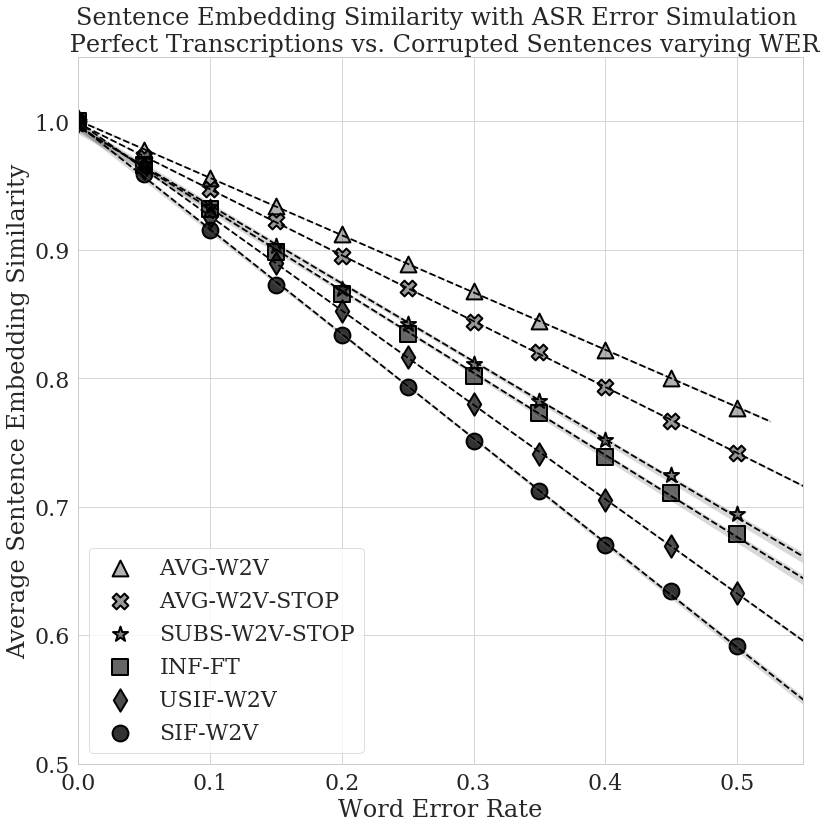

In [66]:
# Markers: '^','v', '.', 'o', '<', '>', 'x', '+', '*', 'd'
#plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.unicode'] = True
plt.rcParams['figure.figsize'] = (13 ,13)

size = 250
plt.figure()

plt.rcParams['axes.prop_cycle'] = monochrome
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2.5)
sns.set_style({'font.family': 'serif'})
sns.despine()

sns.regplot((list(asr_errors_df_all.loc['AVG-W2V', 'ALL'].keys())), 
            (list(asr_errors_df_all.loc['AVG-W2V', 'ALL'].values())), marker='^',
            label='AVG-W2V', scatter_kws={'s':size, 'linewidth':2, "edgecolor":'k',
                                          "color":(0,0,0,0.3),"alpha":None})


sns.regplot(np.array(list(asr_errors_df_all.loc['AVG-W2V-STOP', 'ALL'].keys())), 
            np.array(list(asr_errors_df_all.loc['AVG-W2V-STOP', 'ALL'].values())), marker='X',
            label='AVG-W2V-STOP', scatter_kws={'s':size, 'linewidth':2, "edgecolor":'k',
                                               "color":(0,0,0,0.4),"alpha":None})


sns.regplot(np.array(list(asr_errors_df_all.loc['SUBS-W2V-DIM-STOP', 'ALL'].keys())), 
            2*np.array(list(asr_errors_df_all.loc['SUBS-W2V-DIM-STOP', 'ALL'].values())), marker = '*',
            label='SUBS-W2V-STOP', scatter_kws={'s':size, 'linewidth':2, "edgecolor":'k',
                                                    "color":(0,0,0,0.5),"alpha":None})


sns.regplot(np.array(list(asr_errors_df_all.loc['INF-FT', 'ALL'].keys())), 
            np.array(list(asr_errors_df_all.loc['INF-FT', 'ALL'].values())), marker='s',
            label='INF-FT', scatter_kws={'s':size, 'linewidth':2, "edgecolor":'k',
                                         "color":(0,0,0,0.6),"alpha":None})

sns.regplot(np.array(list(usif_asr_errors_df_all.loc['USIF-W2V', 'ALL'].keys())),
            np.array(list(usif_asr_errors_df_all.loc['USIF-W2V', 'ALL'].values())), marker='d',
            label='USIF-W2V', scatter_kws={'s':size, 'linewidth':2, "edgecolor":'k',
                                           "color":(0,0,0,0.7),"alpha":None})

sns.regplot(np.array(list(asr_errors_df_all.loc['SIF-W2V', 'ALL'].keys())), 
                np.array(list(asr_errors_df_all.loc['SIF-W2V', 'ALL'].values())), marker='o',
                label='SIF-W2V', scatter_kws={'s':size, 'linewidth':2, "edgecolor":'k',
                                              "color":(0,0,0,0.8),"alpha":None})



plt.legend(loc='lower left')

plt.xlim([0, 0.55])
plt.ylim([0.5, 1.05])

plt.xlabel('Word Error Rate')
plt.ylabel('Average Sentence Embedding Similarity')
plt.title('Sentence Embedding Similarity with ASR Error Simulation \n Perfect Transcriptions vs. Corrupted Sentences varying WER')

plt.savefig('../../reports/figures/asr_sentence_embeddings.pdf', format='pdf', dpi=1200)

## Sentence Embeddings + ASR Error

### Averages

In [67]:
from itertools import compress


def run_experiment_sts_original(df, benchmarks): 
    df2 = df.copy()
    sentences1 = [Sentence(s) for s in df2['sent_1']]
    sentences2 = [Sentence(s) for s in df2['sent_2']]
    
    pearson_cors, spearman_cors = [], []
    for label, method in benchmarks:
        sims = method(sentences1, sentences2)
        sims = np.array(sims, dtype=np.float)
        
        # Find indices which are not NaN, only consider those
        valid_idx = np.where(~np.isnan(sims))
        
        pearson_correlation = np.abs(scipy.stats.pearsonr(sims[valid_idx], df2['sim'].iloc[valid_idx])[0])
        print('P:', label, pearson_correlation)
        pearson_cors.append(pearson_correlation)
        spearman_correlation = np.abs(scipy.stats.spearmanr(sims[valid_idx], df2['sim'].iloc[valid_idx])[0])
        print('S:', label, spearman_correlation, '\n')
        spearman_cors.append(spearman_correlation)
        
    return pearson_cors, spearman_cors


def run_experiment_sts_corrupt(df, benchmarks): 
    df2 = df.copy()
    sentences1 = [s for s in df2['sent_1_class']]
    sentences2 = [s for s in df2['sent_2_class']]
    
    pearson_cors, spearman_cors = [], []
    for label, method in benchmarks:
        sims = method(sentences1, sentences2)
        sims = np.array(sims, dtype=np.float)
        
        # Find indices which are not NaN, only consider those
        valid_idx = np.where(~np.isnan(sims))
        
        pearson_correlation = np.abs(scipy.stats.pearsonr(sims[valid_idx], df2['sim'].iloc[valid_idx])[0])
        print('P:', label, pearson_correlation)
        pearson_cors.append(pearson_correlation)
        spearman_correlation = np.abs(scipy.stats.spearmanr(sims[valid_idx], df2['sim'].iloc[valid_idx])[0])
        print('S:', label, spearman_correlation, '\n')
        spearman_cors.append(spearman_correlation)
        
    return pearson_cors, spearman_cors

#### Create corrupted versions for 10% and 30% Error

In [68]:
sts_dev_10 = corrupt_sentences(df=sts_dev, error_rate=0.10, probs_df=probs)
sts_test_10 = corrupt_sentences(df=sts_test, error_rate=0.10, probs_df=probs)
sick_dev_10 = corrupt_sentences(df=sick_dev, error_rate=0.10, probs_df=probs)
sick_test_10 = corrupt_sentences(df=sick_test, error_rate=0.10, probs_df=probs)
sick_all_10 = corrupt_sentences(df=sick_all, error_rate=0.10, probs_df=probs)
sts_all_10 = corrupt_sentences(df=sts_all, error_rate=0.10, probs_df=probs)

sts_dev_30 = corrupt_sentences(df=sts_dev, error_rate=0.30, probs_df=probs)
sts_test_30 = corrupt_sentences(df=sts_test, error_rate=0.30, probs_df=probs)
sick_dev_30 = corrupt_sentences(df=sick_dev, error_rate=0.30, probs_df=probs)
sick_test_30 = corrupt_sentences(df=sick_test, error_rate=0.30, probs_df=probs)
sick_all_30 = corrupt_sentences(df=sick_all, error_rate=0.30, probs_df=probs)
sts_all_30 = corrupt_sentences(df=sts_all, error_rate=0.30, probs_df=probs)


In [69]:
benchmarks2 = [("AVG-W2V", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False)),
              ("AVG-W2V-STOP", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True)),
              #("AVG-GLOVE", ft.partial(run_avg_benchmark, model=glove, use_stoplist=False)),
              ("SIF-W2V", ft.partial(run_sif_benchmark, freqs=frequencies, model=word2vec, use_stoplist=False)),
              #("SIF-GLOVE", ft.partial(run_sif_benchmark, freqs=frequencies, model=glove, use_stoplist=False)),
              #("SUBS-W2V-VAR", ft.partial(run_subspace_benchmark, model=word2vec, method='variance', retained_var=0.8, use_stoplist=False)),
              #("SUBS-GLOVE-VAR", ft.partial(run_subspace_benchmark, model=glove, method='variance', retained_var=0.8, use_stoplist=False)),
              ("SUBS-W2V", ft.partial(run_subspace_benchmark, model=word2vec, method='dimensions', use_stoplist=False)),
              ("SUBS-W2V-STOP", ft.partial(run_subspace_benchmark, model=word2vec, method='dimensions', use_stoplist=True)),
              #("SUBS-GLOVE", ft.partial(run_subspace_benchmark, model=glove, method='dimensions', use_stoplist=False)),
              #("SUBS-GLOVE-STOP", ft.partial(run_subspace_benchmark, model=glove, method='dimensions', use_stoplist=True)),
              #("SIF-SUBS-W2V", ft.partial(run_sif_subspace_benchmark, model=word2vec, use_stoplist=False, method='princ_angle', freqs=frequencies)),
              #("SIF-SUBS-GLOVE", ft.partial(run_sif_subspace_benchmark, model=glove, use_stoplist=False, method='princ_angle', freqs=frequencies)),
              ("INF-FT", ft.partial(run_inf_benchmark, vectors='fasttext')),
              #("INF-GLOVE", ft.partial(run_inf_benchmark, vectors='glove')),
              ("USIF-W2V", ft.partial(run_usif_benchmark, freqs=frequencies, model=word2vec, use_stoplist=False)) 
              #("USIF-GLOVE", ft.partial(run_usif_benchmark, freqs=frequencies, model=glove, use_stoplist=False))
              ]


pearson_results, spearman_results = {}, {}
pearson_results["SICK-DEV"], spearman_results["SICK-DEV"] = run_experiment_sts_original(sick_dev, benchmarks2)
pearson_results["SICK-TEST"], spearman_results["SICK-TEST"] = run_experiment_sts_original(sick_test, benchmarks2)
pearson_results["STS-DEV"], spearman_results["STS-DEV"] = run_experiment_sts_original(sts_dev, benchmarks2)
pearson_results["STS-TEST"], spearman_results["STS-TEST"] = run_experiment_sts_original(sts_test, benchmarks2)
pearson_results["SICK-ALL"], spearman_results["SICK-ALL"] = run_experiment_sts_original(sick_all, benchmarks2)
pearson_results["STS-ALL"], spearman_results["STS-ALL"] = run_experiment_sts_original(sts_all, benchmarks2)



pearson_results["SICK-DEV-10"], spearman_results["SICK-DEV-10"] = run_experiment_sts_corrupt(sick_dev_10, benchmarks2)
pearson_results["SICK-TEST-10"], spearman_results["SICK-TEST-10"] = run_experiment_sts_corrupt(sick_test_10, benchmarks2)
pearson_results["STS-DEV-10"], spearman_results["STS-DEV-10"] = run_experiment_sts_corrupt(sts_dev_10, benchmarks2)
pearson_results["STS-TEST-10"], spearman_results["STS-TEST-10"] = run_experiment_sts_corrupt(sts_test_10, benchmarks2)  
pearson_results["SICK-ALL-10"], spearman_results["SICK-ALL-10"] = run_experiment_sts_corrupt(sick_all_10, benchmarks2)
pearson_results["STS-ALL-10"], spearman_results["STS-ALL-10"] = run_experiment_sts_corrupt(sts_all_10, benchmarks2)


pearson_results["SICK-DEV-30"], spearman_results["SICK-DEV-30"] = run_experiment_sts_corrupt(sick_dev_30, benchmarks2)
pearson_results["SICK-TEST-30"], spearman_results["SICK-TEST-30"] = run_experiment_sts_corrupt(sick_test_30, benchmarks2)
pearson_results["STS-DEV-30"], spearman_results["STS-DEV-30"] = run_experiment_sts_corrupt(sts_dev_30, benchmarks2)
pearson_results["STS-TEST-30"], spearman_results["STS-TEST-30"] = run_experiment_sts_corrupt(sts_test_30, benchmarks2)
pearson_results["SICK-ALL-30"], spearman_results["SICK-ALL-30"] = run_experiment_sts_corrupt(sick_all_30, benchmarks2)
pearson_results["STS-ALL-30"], spearman_results["STS-ALL-30"] = run_experiment_sts_corrupt(sts_all_30, benchmarks2)



P: AVG-W2V 0.7165220868262591
S: AVG-W2V 0.6242072799068632 

P: AVG-W2V-STOP 0.7014898727970184
S: AVG-W2V-STOP 0.5921433858310173 

P: SIF-W2V 0.7287347356012855
S: SIF-W2V 0.6391509281729675 

P: SUBS-W2V 0.6719761851888352
S: SUBS-W2V 0.6066028875770367 

P: SUBS-W2V-STOP 0.6905863305604841
S: SUBS-W2V-STOP 0.611693466233046 

Found 1123(/1124) words with w2v vectors
Vocab size : 1123
P: INF-FT 0.7655393129003623
S: INF-FT 0.7162515522649883 

P: USIF-W2V 0.7311258548815602
S: USIF-W2V 0.6392467849261009 

P: AVG-W2V 0.7296376427373978
S: AVG-W2V 0.6239765660177079 

P: AVG-W2V-STOP 0.7140806452508383
S: AVG-W2V-STOP 0.5833534770035378 

P: SIF-W2V 0.7350598943927457
S: SIF-W2V 0.6351044142457498 

P: SUBS-W2V 0.6660173589502587
S: SUBS-W2V 0.5841024509597799 

P: SUBS-W2V-STOP 0.6573041593864658
S: SUBS-W2V-STOP 0.5696399545357586 

Found 2266(/2272) words with w2v vectors
Vocab size : 2266
P: INF-FT 0.7587982108498517
S: INF-FT 0.7015039810810677 

P: USIF-W2V 0.7377454197752443


P: USIF-W2V 0.4143903197118973
S: USIF-W2V 0.37444740663348736 

P: AVG-W2V 0.5060959907616137
S: AVG-W2V 0.42555933117458017 

P: AVG-W2V-STOP 0.49536781740130764
S: AVG-W2V-STOP 0.42269226651657416 

P: SIF-W2V 0.5293498973525531
S: SIF-W2V 0.4670212207692881 

P: SUBS-W2V 0.4619203301410384
S: SUBS-W2V 0.4113335892076627 

P: SUBS-W2V-STOP 0.4640249928891777
S: SUBS-W2V-STOP 0.41983422830115696 

Found 6045(/6057) words with w2v vectors
Vocab size : 6045
P: INF-FT 0.568543856791525
S: INF-FT 0.510498099394584 

P: USIF-W2V 0.5321093281192119
S: USIF-W2V 0.46520823129420863 

P: AVG-W2V 0.4512531213049175
S: AVG-W2V 0.4398876555925675 

P: AVG-W2V-STOP 0.5041108924090975
S: AVG-W2V-STOP 0.5073181306359233 

P: SIF-W2V 0.5230637762841437
S: SIF-W2V 0.5133964616951908 

P: SUBS-W2V 0.4832965837436752
S: SUBS-W2V 0.4763777672189784 

P: SUBS-W2V-STOP 0.5378450495637123
S: SUBS-W2V-STOP 0.5290618606170817 

Found 12376(/12691) words with w2v vectors
Vocab size : 12376
P: INF-FT 0.5552241

## Results

Let's take a look at our results. We'll mostly work with Pearson correlation, as is standard in the literature, except where Spearman correlation sheds additional light on our findings.

In [70]:
plt.rcParams['figure.figsize'] = (10,5)

pearson_results_df = pd.DataFrame(pearson_results)
pearson_results_df = pearson_results_df.transpose()
pearson_results_df = pearson_results_df.rename(columns={i:b[0] for i, b in enumerate(benchmarks2)})
pearson_results_df = pearson_results_df.transpose()
pearson_results_df = pearson_results_df.rename(index={'SUBS-W2V-DIM':'SUBS-W2V', 'SUBS-W2V-DIM-STOP':'SUBS-W2V-STOP'})


spearman_results_df = pd.DataFrame(spearman_results)
spearman_results_df = spearman_results_df.transpose()
spearman_results_df = spearman_results_df.rename(columns={i:b[0] for i, b in enumerate(benchmarks2)})
spearman_results_df = spearman_results_df.transpose()



with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print('Pearson Results\n')
    display(pearson_results_df)

    print('\nSpearman Results\n')
    display(spearman_results_df)




Pearson Results



,SICK-DEV,SICK-TEST,STS-DEV,STS-TEST,SICK-ALL,STS-ALL,SICK-DEV-10,SICK-TEST-10,STS-DEV-10,STS-TEST-10,SICK-ALL-10,STS-ALL-10,SICK-DEV-30,SICK-TEST-30,STS-DEV-30,STS-TEST-30,SICK-ALL-30,STS-ALL-30
AVG-W2V,0.7165,0.7296,0.7146,0.6245,0.7284,0.6740,0.6449,0.6405,0.6408,0.5459,0.6351,0.6004,0.4848,0.5111,0.4897,0.3777,0.5061,0.4513
AVG-W2V-STOP,0.7015,0.7141,0.7512,0.6095,0.7130,0.6861,0.6350,0.6282,0.6958,0.5326,0.6227,0.6299,0.4926,0.5037,0.5733,0.4058,0.4954,0.5041
SIF-W2V,0.7287,0.7351,0.7481,0.6620,0.7344,0.7039,0.6551,0.6618,0.6895,0.5874,0.6523,0.6424,0.5198,0.5396,0.5871,0.4256,0.5293,0.5231
SUBS-W2V,0.6720,0.6660,0.7108,0.6188,0.6665,0.6671,0.6273,0.5881,0.6508,0.5308,0.5815,0.6046,0.4569,0.4608,0.5474,0.3830,0.4619,0.4833
SUBS-W2V-STOP,0.6906,0.6573,0.7375,0.6817,0.6605,0.7154,0.6368,0.5978,0.6997,0.5891,0.5931,0.6560,0.5099,0.4766,0.5730,0.4330,0.4640,0.5378
INF-FT,0.7655,0.7588,0.7849,0.7059,0.7594,0.7477,0.7071,0.6896,0.7191,0.6400,0.6808,0.6889,0.5814,0.5656,0.5954,0.4951,0.5685,0.5552
USIF-W2V,0.7311,0.7377,0.7455,0.6497,0.7370,0.6995,0.6578,0.6623,0.6850,0.5770,0.6528,0.6358,0.5199,0.5415,0.5763,0.4144,0.5321,0.5126



Spearman Results



,SICK-DEV,SICK-TEST,STS-DEV,STS-TEST,SICK-ALL,STS-ALL,SICK-DEV-10,SICK-TEST-10,STS-DEV-10,STS-TEST-10,SICK-ALL-10,STS-ALL-10,SICK-DEV-30,SICK-TEST-30,STS-DEV-30,STS-TEST-30,SICK-ALL-30,STS-ALL-30
AVG-W2V,0.6242,0.6240,0.7275,0.5835,0.6241,0.6662,0.5515,0.5505,0.6495,0.4959,0.5437,0.5909,0.4003,0.4362,0.4950,0.3394,0.4256,0.4399
AVG-W2V-STOP,0.5921,0.5834,0.7486,0.6354,0.5845,0.6981,0.5444,0.5314,0.6921,0.5455,0.5278,0.6315,0.4019,0.4307,0.5769,0.3991,0.4227,0.5073
SIF-W2V,0.6392,0.6351,0.7453,0.6131,0.6356,0.6846,0.5705,0.5757,0.6861,0.5310,0.5674,0.6188,0.4514,0.4782,0.5897,0.3861,0.4670,0.5134
SUBS-W2V,0.6066,0.5841,0.7063,0.5979,0.5864,0.6559,0.5663,0.5223,0.6505,0.5053,0.5181,0.5903,0.4080,0.4133,0.5513,0.3570,0.4113,0.4764
SUBS-W2V-STOP,0.6117,0.5696,0.7294,0.6431,0.5739,0.6979,0.5591,0.5362,0.6891,0.5480,0.5318,0.6305,0.4670,0.4339,0.5709,0.4054,0.4198,0.5291
INF-FT,0.7163,0.7015,0.7841,0.6839,0.7029,0.7367,0.6534,0.6270,0.7188,0.6065,0.6183,0.6735,0.5137,0.5075,0.5976,0.4618,0.5105,0.5422
USIF-W2V,0.6392,0.6346,0.7453,0.6001,0.6351,0.6811,0.5720,0.5740,0.6830,0.5202,0.5651,0.6144,0.4461,0.4764,0.5788,0.3744,0.4652,0.5022


In [71]:
pearson_results_df.to_csv('pearson_results.csv')

spearman_results_df.to_csv('spearman_results.csv')

### PCC Plots with varying Error


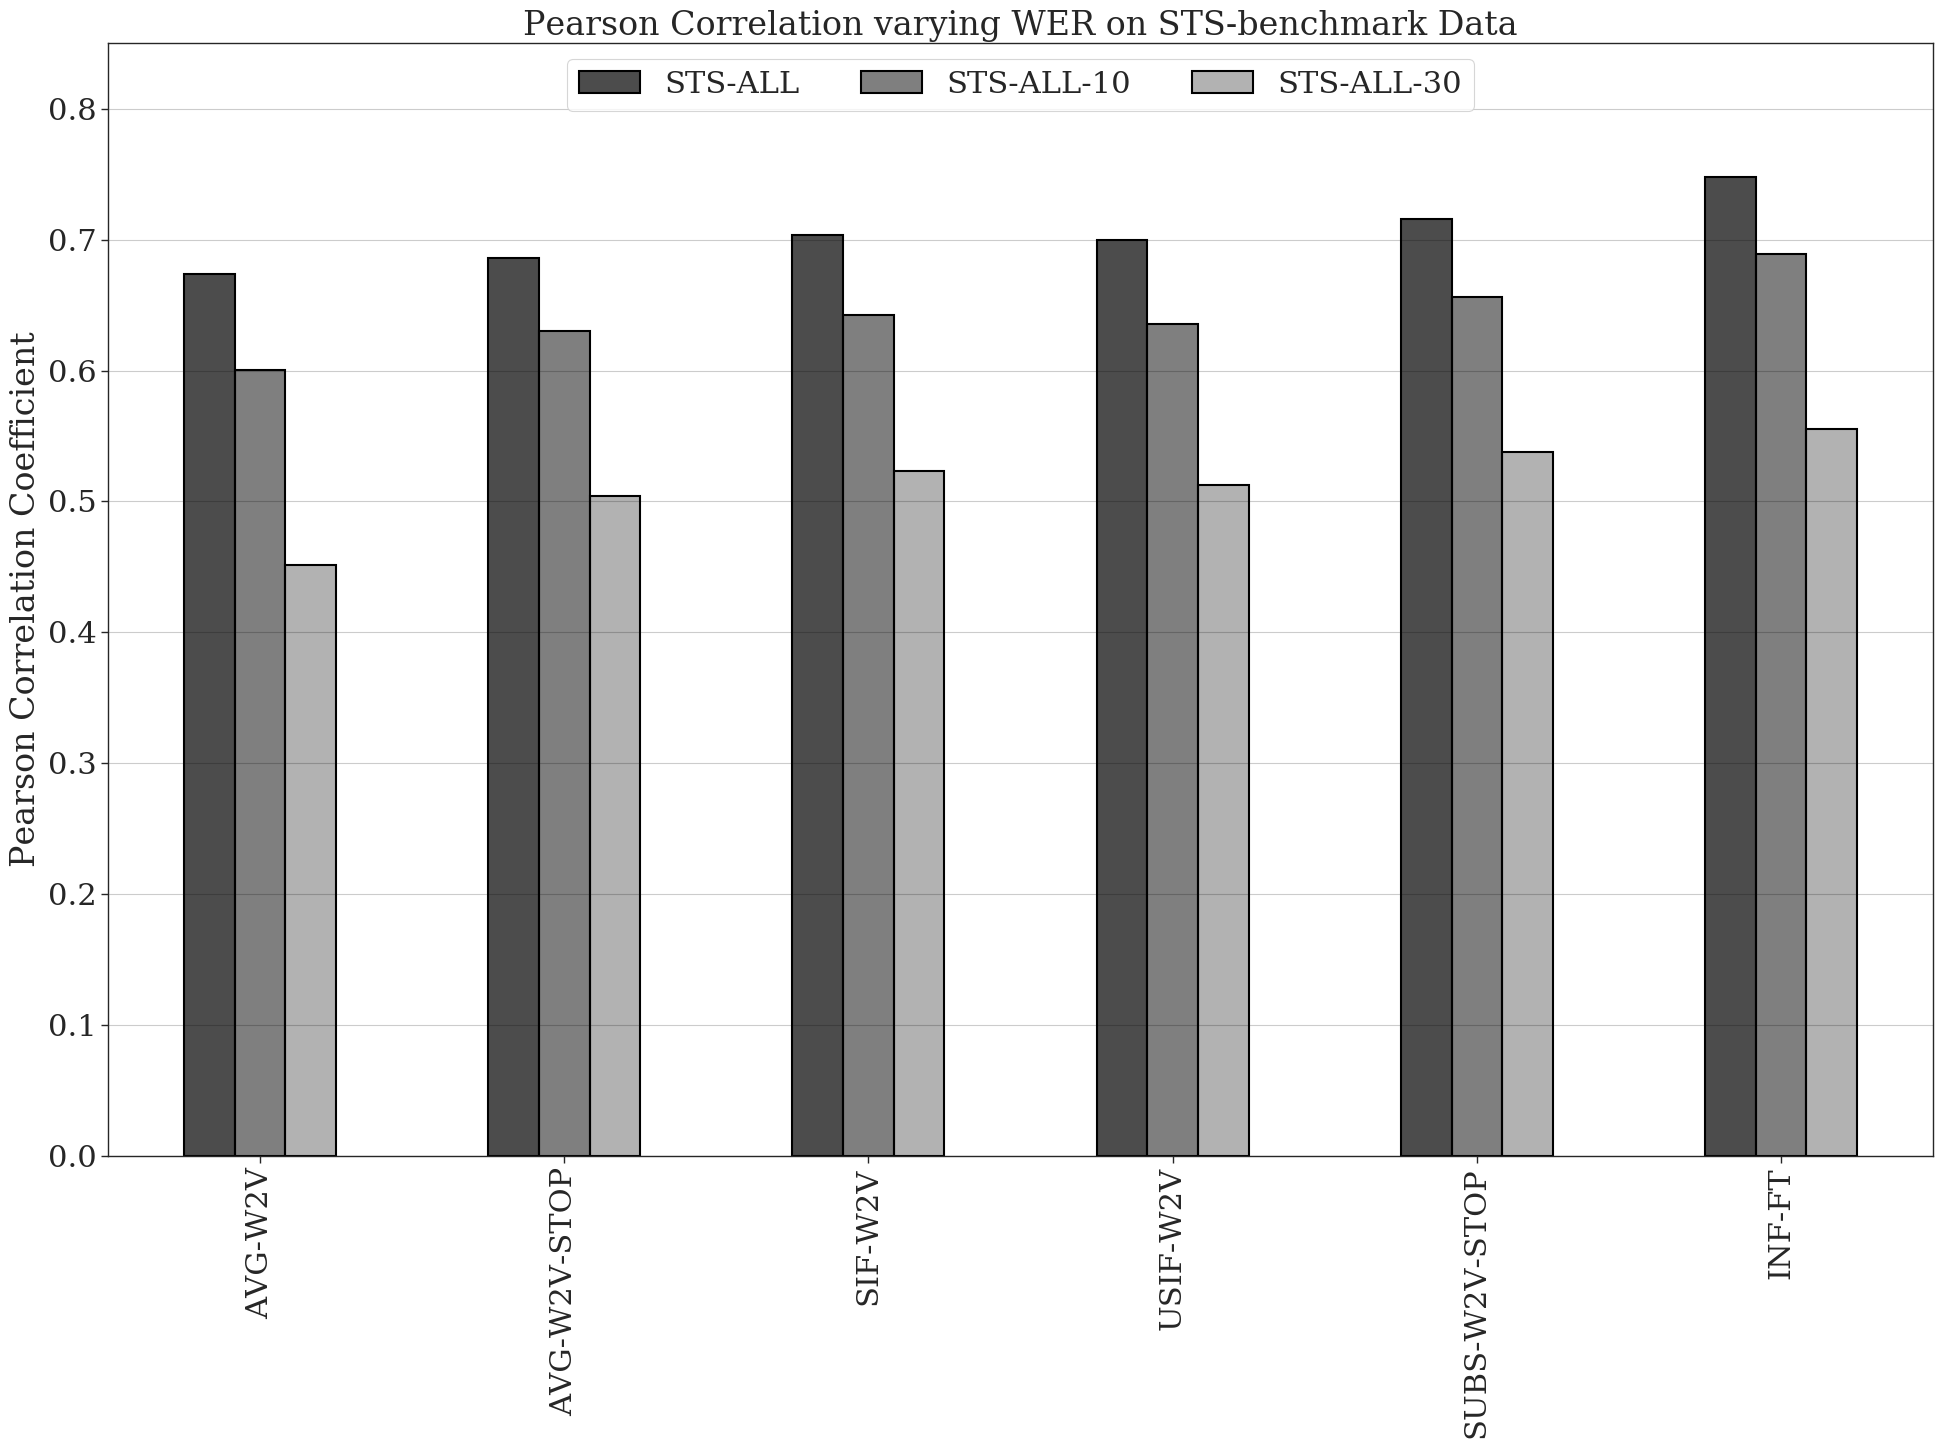

In [72]:
plt.rcdefaults()
plt.rcParams['figure.figsize'] = (20, 15)
plt.rcParams['axes.prop_cycle'] = monochrome
sns.set_style('ticks')
sns.set_context('paper', font_scale=2.5)
sns.set_style({'font.family': 'serif'})


ax1 = pearson_results_df.loc[("AVG-W2V", "AVG-W2V-STOP", "SIF-W2V", "USIF-W2V", "SUBS-W2V-STOP", "INF-FT"), ('STS-ALL', 'STS-ALL-10', 'STS-ALL-30')].plot(kind="bar", 
title="Pearson Correlation varying WER on STS-benchmark Data", legend=False, edgecolor='k')


for container, hatch, alpha in zip(ax1.containers, ("--", "//", "xx"), (0.7, 0.5, 0.3)):
    for patch in container.patches:
        #patch.set_hatch(hatch)
        patch.set_facecolor((0,0,0,alpha))
        patch.set_lw(1.5)
        
ax1.yaxis.grid()
ax1.legend(loc='upper center', ncol=3)
plt.ylabel('Pearson Correlation Coefficient')
plt.ylim([0, 0.85])
plt.tight_layout()

sts = plt.gcf()

sts.savefig('../../reports/figures/WER-Pearson-STS.pdf', format='pdf')


In [73]:
sts.add_subplot(212)

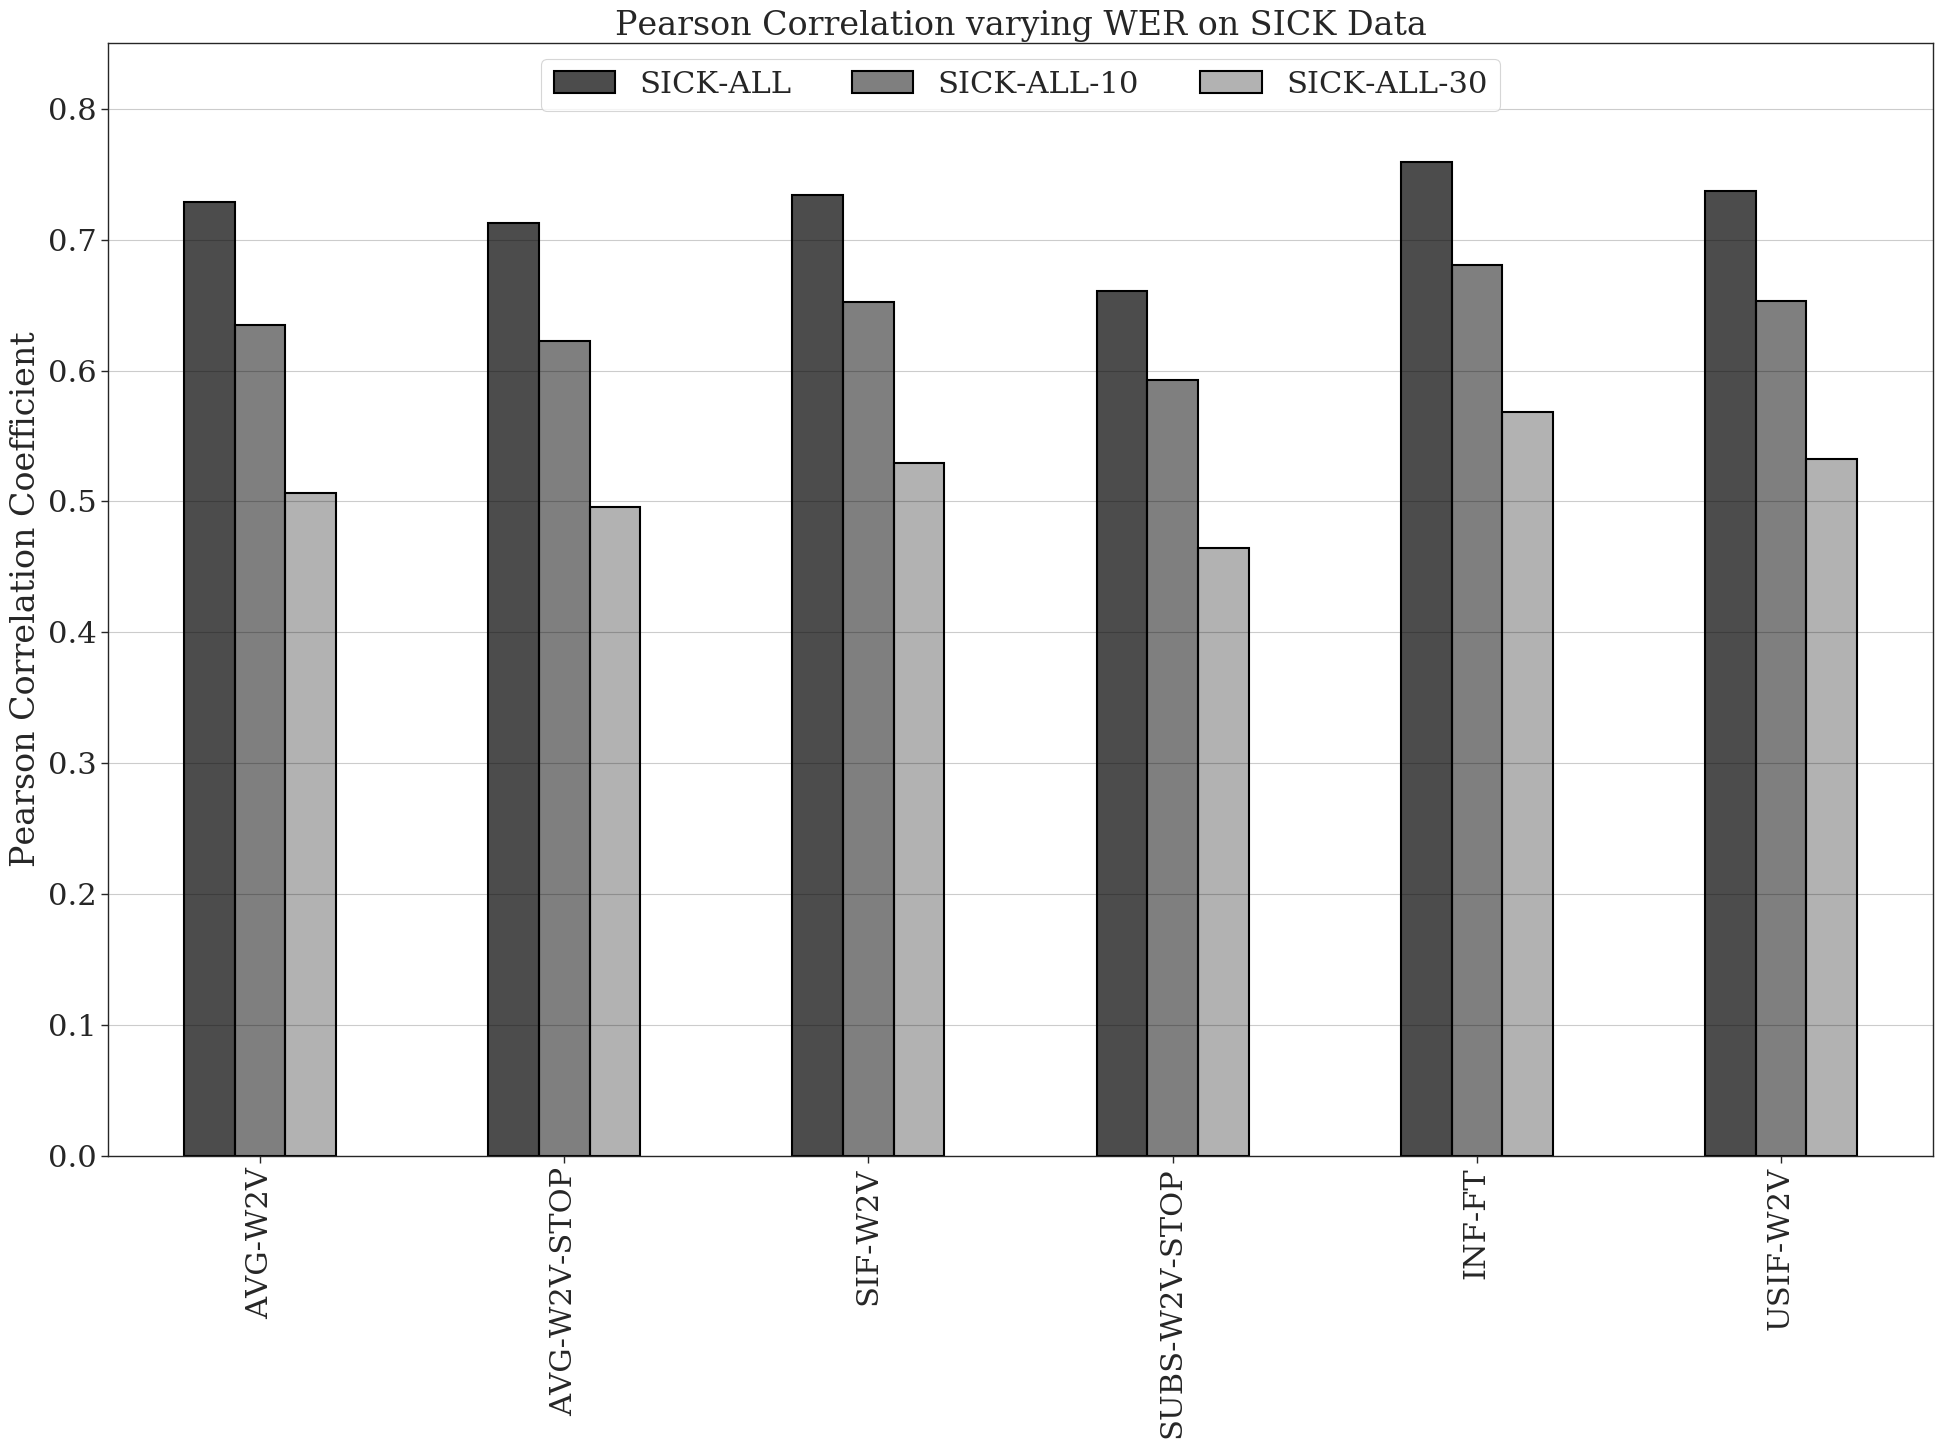

In [74]:
ax2 =pearson_results_df.loc[("AVG-W2V", "AVG-W2V-STOP", "SIF-W2V", "SUBS-W2V-STOP", "INF-FT", "USIF-W2V"), 
                       ('SICK-ALL', 'SICK-ALL-10', 'SICK-ALL-30')].plot(
    kind="bar", title='Pearson Correlation varying WER on SICK Data', legend=False, edgecolor='k')

for container, hatch, alpha in zip(ax2.containers, ("--", "//", "xx"), (0.7, 0.5, 0.3)):
    for patch in container.patches:
        #patch.set_hatch(hatch)
        patch.set_facecolor((0,0,0,alpha))
        patch.set_lw(1.5)
ax2.yaxis.grid()
ax2.legend(loc='upper center', ncol=3)

plt.ylabel('Pearson Correlation Coefficient')
plt.ylim([0, 0.85])
plt.tight_layout()

sick = plt.gcf()

sick.savefig('../../reports/figures/WER-Pearson-SICK.pdf', format='pdf')

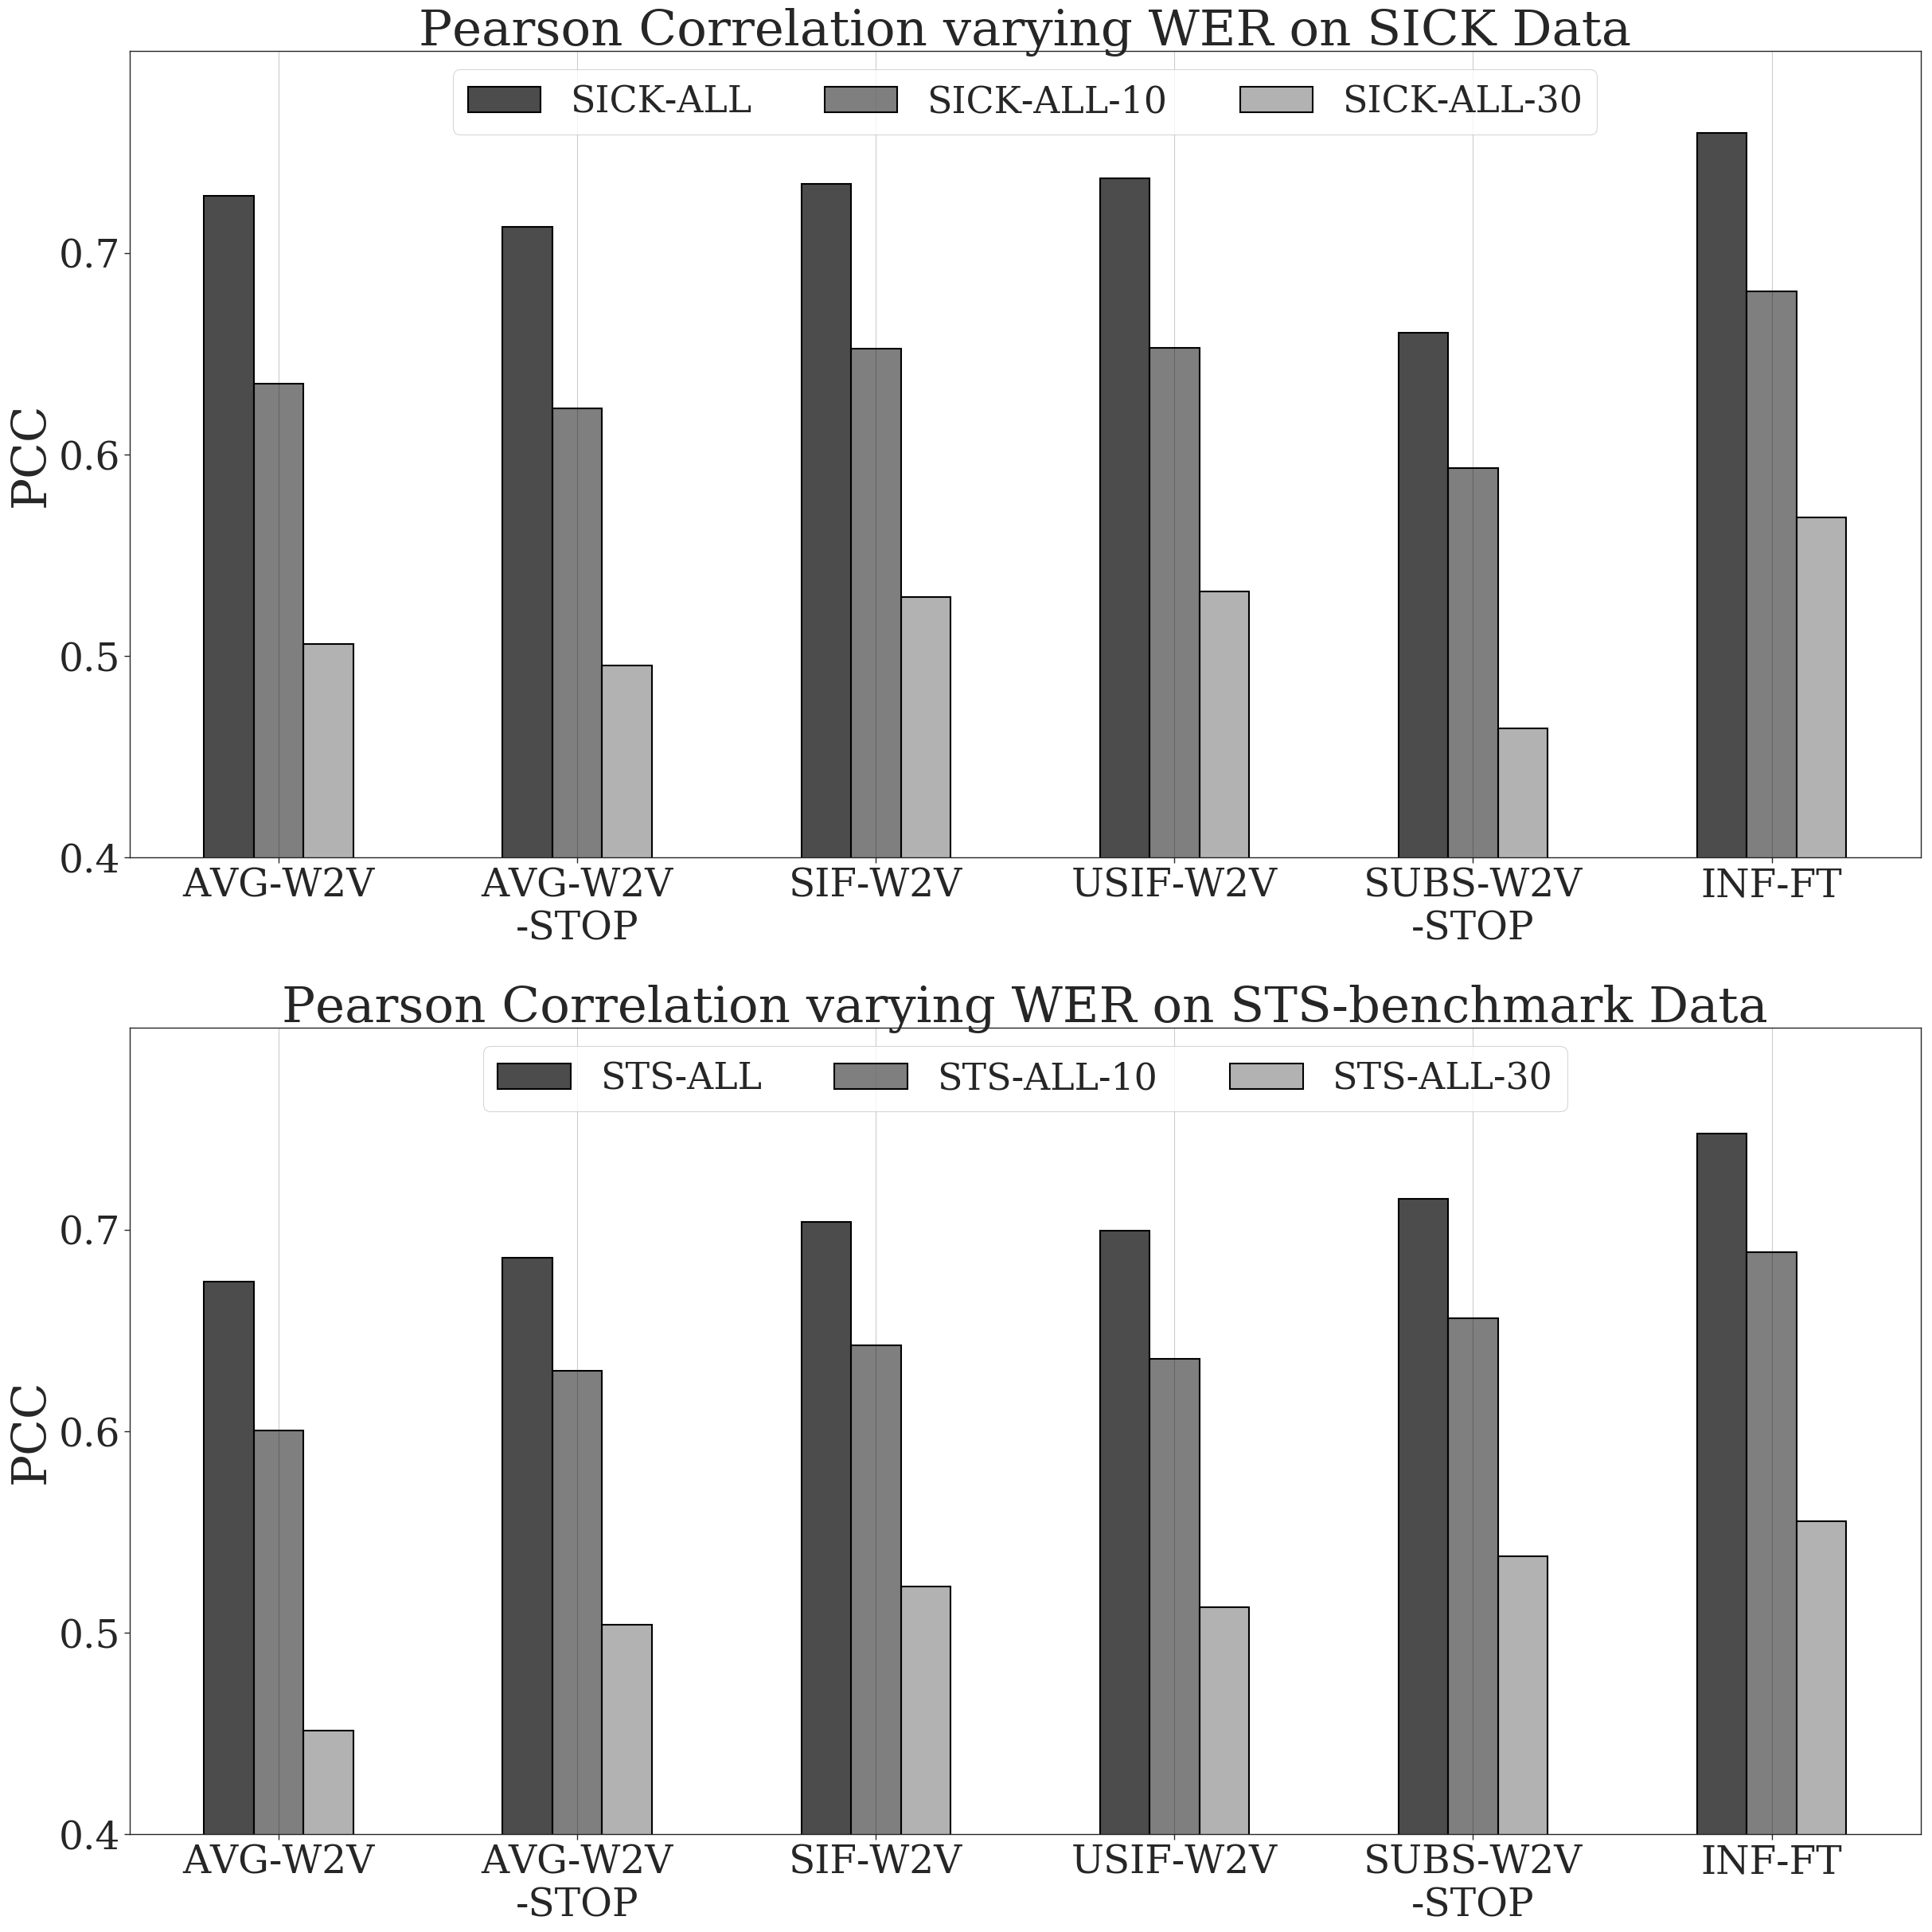

In [75]:
plt.rcParams['figure.figsize'] = (25, 25)
sns.set_context('paper', font_scale=3.2)

fig, ax = plt.subplots(2,1)

pearson_results_df.loc[("AVG-W2V", "AVG-W2V-STOP", "SIF-W2V", 'USIF-W2V', "SUBS-W2V-STOP", "INF-FT"), 
                       ('SICK-ALL', 'SICK-ALL-10', 'SICK-ALL-30')].plot(ax=ax[0],
    kind="bar", title=None, legend=False, edgecolor='k')

for container, hatch, alpha in zip(ax[0].containers, ("--", "//", "xx"), (0.7, 0.5, 0.3)):
    for patch in container.patches:
        #patch.set_hatch(hatch)
        patch.set_facecolor((0,0,0,alpha))
        patch.set_lw(1.5)
ax[0].xaxis.grid()
ax[0].legend(loc='upper center', ncol=3, fontsize=33)
ax[0].set_ylabel('PCC', fontsize=43)
ax[0].set_title('Pearson Correlation varying WER on SICK Data', fontsize=45)
ax[0].set_ylim([0.4, 0.8])
ax[0].set_yticks(np.arange(0.4, 0.8, step=0.1))
ax[0].set_xticklabels(labels=("AVG-W2V", "AVG-W2V\n-STOP", "SIF-W2V", 'USIF-W2V', "SUBS-W2V\n-STOP", "INF-FT"), rotation=0, fontsize=35)
ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=35)

pearson_results_df.loc[("AVG-W2V", "AVG-W2V-STOP", "SIF-W2V", "USIF-W2V", "SUBS-W2V-STOP", "INF-FT"), ('STS-ALL', 'STS-ALL-10', 'STS-ALL-30')].plot(
    ax=ax[1], kind="bar", title=None, legend=False, edgecolor='k')


for container, hatch, alpha in zip(ax[1].containers, ("--", "//", "xx"), (0.7, 0.5, 0.3)):
    for patch in container.patches:
        #patch.set_hatch(hatch)
        patch.set_facecolor((0,0,0,alpha))
        patch.set_lw(1.5)     
ax[1].xaxis.grid()
ax[1].legend(loc='upper center', ncol=3, fontsize=33)
ax[1].set_ylabel('PCC', fontsize=43)
ax[1].set_title("Pearson Correlation varying WER on STS-benchmark Data", fontsize=45)
ax[1].set_ylim([0.4, 0.8])
ax[1].set_yticks(np.arange(0.4, 0.8, step=0.1))
ax[1].set_xticklabels(labels=("AVG-W2V", "AVG-W2V\n-STOP", "SIF-W2V", 'USIF-W2V', "SUBS-W2V\n-STOP", "INF-FT"), rotation=0, fontsize=35)
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=35)


plt.tight_layout()
plt.savefig('../../reports/figures/PCC_WER.pdf', format='pdf', dpi=1200)

### Smooth Inverse Frequency

Smooth Inverse Frequency is the most consistent performer in our tests. On the SICK data, it does about as well as its baseline competitors, on STS it outranks them by a clear margin. Note there is little difference between SIF with word2vec embeddings and SIF with GloVe embeddings. This is remarkable, given the large differences we observed above. It shows SIF's weighting and common component removal is a very effective alternative to using a stoplist.